# Stratospheric Polar Vortex Diagnostics: An analysis with Numeric Weather Predictions
This notebook demonstrates the application of the *arctic* Python package to analyze the geometry and dynamics of the stratospheric polar vortex (SPV). The focus is on an analysis of the geometric vortex moments and their classification. The methodology aligns closely to the one used by Hannachi et al. (2011) and is modified according to the datas structure.

# Table of Contents
- [Introduction](#introduction)
- [Data](#data)
- [Methodology](#methodology)
    - [Reconstruction of same conditions as H11](#reconstruction-of-same-conditions-as-h11)
    - [Scaling](#scaling)
    - [Seasonality](#seasonality)
        - [Durbin Watson Test](#durbin-watson-test)
        - [Autocorrelation Function](#autocorrelation-function)
        - [Extended Emirical Orthogonal Function](#extended-empirical-orthogonal-function)
        - [Single Spectrum Analysis](#single-spectrum-analysis)
    - [Gap statistic](#gap-statistic)
    - [Hierarchical clustering](#hierarchical-clustering)
- [Results](#results)
    - [Statistical Profiles of Clusters](#statistical-profiles-of-clusters)
    - [Physical Interpretation and Literature Comparison](#physical-interpretation-and-literature-comparison)
- [Appendix](#appendix)
    - [Partial Autocorrelation](#computation-of-the-partial-autocorrelation-function)
    - [Year over Year Averages](#year-over-year-averages)
    - [Abbreviations](#abbreviations)

# Introduction
The stratospheric polar vortex (SPV) plays a central role in modulating mid-latitude weather patterns, particularly during winter. Sudden stratospheric warming (SSW) events, which can split or displace the vortex, are of great interest due to their impacts on the troposphere.

This study builds upon the methodology of Hannachi et al. (2011, hereafter H11), who used geometric moments derived from potential vorticity fields to characterize vortex morphology. Here, we apply similar techniques to the extracted features from the numerical weather prediction (NWP) using the Icosahedral Nonhydrostatic (ICON) general circulation model with upper atmosphere (UA-ICON). We aim to replicate and assess H11's clustering results using elliptic indices. Further, the results provide an impression about the models ability to captures extreme vortex events.

# Data
The data used in this study were provided and preprocessed by the Institute of Atmospheric Physics (IAP) in Kühlungsborn. It includes daily diagnostics from the NWP of the UA-ICON model, derived using the IDL-based ELDI and SSW packages. To be concrete, the data include the daily elliptic indices of the stratospheric polar vortex at 10hPa geopotential height and major warming diagnostics.

The data are split into three files:

- `*_cen.csv`: Contains event-centered diagnostics, including central SSW dates, i.e. when the wind reversed form westerly to easterly, persistence, maximum eastward wind, intensity, and accumulated intensity.
- `*_msw.csv`: Flags daily major warming events with corresponding zonally averaged wind speeds.
- `*_d.csv`: Includes daily geometric vortex diagnostics: area, centroid latitude/longitude (latcent, loncent), aspect ratio (ar), orientation angle (theta), and kurtosis. This file also marks split events (S) and includes diagnostics for identified sub-vortices, along with wave diagnostics at 60° latitude.

The dataset spans 1979–2040 and includes the same indices used in the full analysis demonstration replicating the results of Hannachi et al. (2011) on ERA5 reanalysis data. This analysis will focus on the following geometric moments: area, aspect ratio (ar), centroid latit

In [1]:
# import arctic in general
import arctic

# import other important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import specific functions from arctic
from arctic.io.loader import read_data
from arctic.io.cleaner import no_white_space, to_date

# read data
nwp_d = read_data("../data/SWXClust/NWP4A60/i4a60e2_d.csv")
nwp_cen = read_data("../data/SWXClust/NWP4A60/i4a60m2t-cen.csv")
nwp_msw = read_data("../data/SWXClust/NWP4A60/i4a60m2t-msw.csv")

# remove white space from column names
no_white_space(nwp_d)
no_white_space(nwp_cen)
no_white_space(nwp_msw)

# change string to datetime for better comparison
to_date(nwp_d, 'string', format='%d.%m.%Y-%H:%M:%S')
to_date(nwp_cen, 'string', format='%d.%m.%Y-%H:%M')
to_date(nwp_msw, 'string', format='%d.%m.%Y-%H:%M')

# convert columns to numeric
col_convert = [
    'area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1',
    'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'
]
nwp_d[col_convert] = nwp_d[col_convert].apply(pd.to_numeric, errors='coerce')
nwp_d = nwp_d.fillna(0)

# merge nwp data to one big dataframe
nwp_all = nwp_d.merge(nwp_msw, on ='string', how='left', suffixes=[None, '_msw']).\
    merge(nwp_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
from sklearn.preprocessing import LabelEncoder
le_mw = LabelEncoder()
nwp_all['MW'] = le_mw.fit_transform(nwp_all.MW)
print(f"Transformed 'MW':\n{le_mw.inverse_transform([1])} to 1\n{le_mw.inverse_transform([0])} to 0")
le_form = LabelEncoder()
nwp_all['form'] = le_form.fit_transform(nwp_all.form)
print(f"Transformed 'form': \n {le_form.inverse_transform([1])} to 1\n{le_form.inverse_transform([0])} to 0")

# handling NaN values and string encodings
nwp_all[nwp_cen.columns[-4:]] = nwp_all[nwp_cen.columns[-4:]].fillna(0)

# drop constant columns
nwp_all.drop(['D_d', 'level', 'hour',
               'D_cen', 'num', 'counter_cen', 'time_cen',
               'D_msw', 'counter_msw', 'time_msw'
               ], axis=1, inplace=True)
# sort by date
nwp_all = nwp_all.sort_values('string').reset_index(drop=True)

# check
nwp_all.info()

Transformed 'MW':
['MW'] to 1
[''] to 0
Transformed 'form': 
 ['S'] to 1
['D'] to 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22462 entries, 0 to 22461
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   counter_d  22462 non-null  int64         
 1   time_d     22462 non-null  float64       
 2   string     22462 non-null  datetime64[ns]
 3   year       22462 non-null  int64         
 4   month      22462 non-null  int64         
 5   day        22462 non-null  int64         
 6   edge       22462 non-null  float64       
 7   form       22462 non-null  int64         
 8   area       22462 non-null  float64       
 9   obj_area   22462 non-null  float64       
 10  latcent    22462 non-null  float64       
 11  loncent    22462 non-null  float64       
 12  theta      22462 non-null  float64       
 13  ar         22462 non-null  float64       
 14  kurtosis   22462 non-null  float64       
 15  are

# Methodology
## Reconstruction of same conditions as H11
In H11, a winter period (december to march, DJFM) is selected and data range from 1958 to 2002. The authors note activity peaks in dec - jan and an oscillation period around 120-130d. As mentioned before, the NWP data range from 1979 to 2040. The diagrams below depict the consecutive days of DJFM. For a better orientation a second axis with the respective dates is added, though still all other month are skipped. Hence, March is followed by December.

## Scaling
Normalization broadly refers to any generic alteration of data making them more compatible (Gewers et al. 2021). Common approach are *MinMax* scaling, i.e. each feature has a given range $\left[min, max\right]$, or *Standard* scaling as given below, i.e. each variable has a mean of zero and variance of one.

$$x' = \frac{x-\mu}{\sigma}$$

It is not explicitly mentioned which methods were used for scaling. A look at the timeseries diagrams suggest a StandardScaler is used in H11.

## Time series of scaled AR, Latcent, Area and kurtosis
Below the time series of the scaled aspect ratio (ar), centroid latitude (latcent), area, and kurtosis are displayed. First the data are reduced to DJFM and then scaled with the Standard Scaler.
The kurtosis is dominated by a few outliers and is therefore ommitted for the remainder of the analysis. Instead the wind speed is used.

In [3]:
from sklearn.preprocessing import StandardScaler

# scale on entire data
sc = StandardScaler()
# time constraints
nwp_winter = nwp_all[nwp_all['month'].isin([12,1,2,3])]
nwp_winter.reset_index(drop=True, inplace=True)

# only geometric moments + wind speed
nwp_geo = nwp_winter[['string', 'year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis', 'u', 'edge']]
# scale on DJFM
foi = ['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u', 'scaled_edge']
nwp_geo.loc[:, foi] = sc.fit_transform(nwp_geo[['area', 'ar', 'latcent', 'kurtosis', 'u', 'edge']])

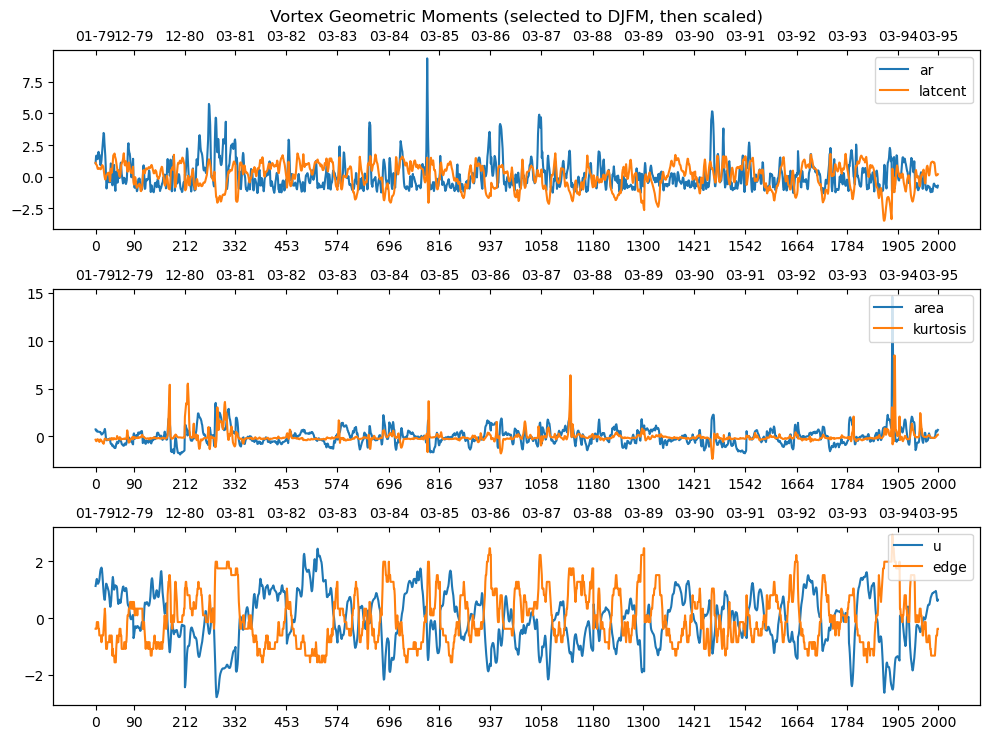

In [4]:
time_span = 2000
positions = [0]
positions[1: ] = [x for x in range(90, time_span, 121)]
for i in range(len(positions)):
    if nwp_geo.loc[positions[i], 'string'].year % 400 == 0:
        positions[i] = positions[i] +1
        continue
    if nwp_geo.loc[positions[i], 'string'].year % 4 == 0:
        positions[i] = positions[i] + 1
        continue

positions.append(time_span)

from arctic.workflows.demo import plot_timeseries_moments
plot_timeseries_moments(nwp_geo,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis', 'scaled_u', 'scaled_edge'],
                        ['ar', 'latcent', 'area', 'kurtosis', 'u', 'edge'],
                        title = 'Vortex Geometric Moments (selected to DJFM, then scaled)',
                        time_span=time_span,
                        positions=positions,
                        num_plots=3,
                        figsize=(10,7.5))

## Seasonality

### Durbin-Watson Test

The Durbin-Watson test is used to detect the presence of first order autocorrelation in the residuals of a regression model. It assumes that:

- The residuals (errors) are normally distributed with a mean of 0
- The residuals are stationary over time

Commonly, it is interpretated as follows:
- **0 to 1.5**: strong **positive autocorrelation**
- **1.5 to 2.5**: little to **no autocorrelation**
- **2.5 to 4**: strong **negative autocorrelation**

In this analysis, the Durbin-Watson test indicates strong positive autocorrelation in the data, which is consistent with findings by H11.

In [5]:
from statsmodels.stats.stattools import durbin_watson

for feature in foi:
    dw = durbin_watson(nwp_geo[feature])
    print(f"Durbin-Watson statistic on {feature}: {np.round(dw, 3)}")

Durbin-Watson statistic on scaled_area: 0.163
Durbin-Watson statistic on scaled_ar: 0.215
Durbin-Watson statistic on scaled_latcent: 0.082
Durbin-Watson statistic on scaled_kurtosis: 0.445
Durbin-Watson statistic on scaled_u: 0.033
Durbin-Watson statistic on scaled_edge: 0.058


### Autocorrelation function
To further investigate seasonality, the autocorrelation function (ACF) is used. The ACF measures how well the time series correlates with lagged versions of itself. It is defined at lag $k$ as follows

$$\rho_k = \frac{Cov(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

and computed on unit vector normalised data. Importantly, scaling does not affect the shape of the autocorrelation, as the operation is inherently scale-invariant.

The dashed horizontal lines in the plots represent 5% significance bounds of the autocorrelation. An autocorrelation above or below, indicates a significant correlation at that lag.
For the wind speed and edge a significant autocorrelation was detected. Consequently, these features will be filtered in the next step. The retrieved autocorrelation matches roughly the 120-day signal as found by H11.

⚠ For large lag values, ACF computation can become slow. It is recommended to use lags between 500 and 1500.

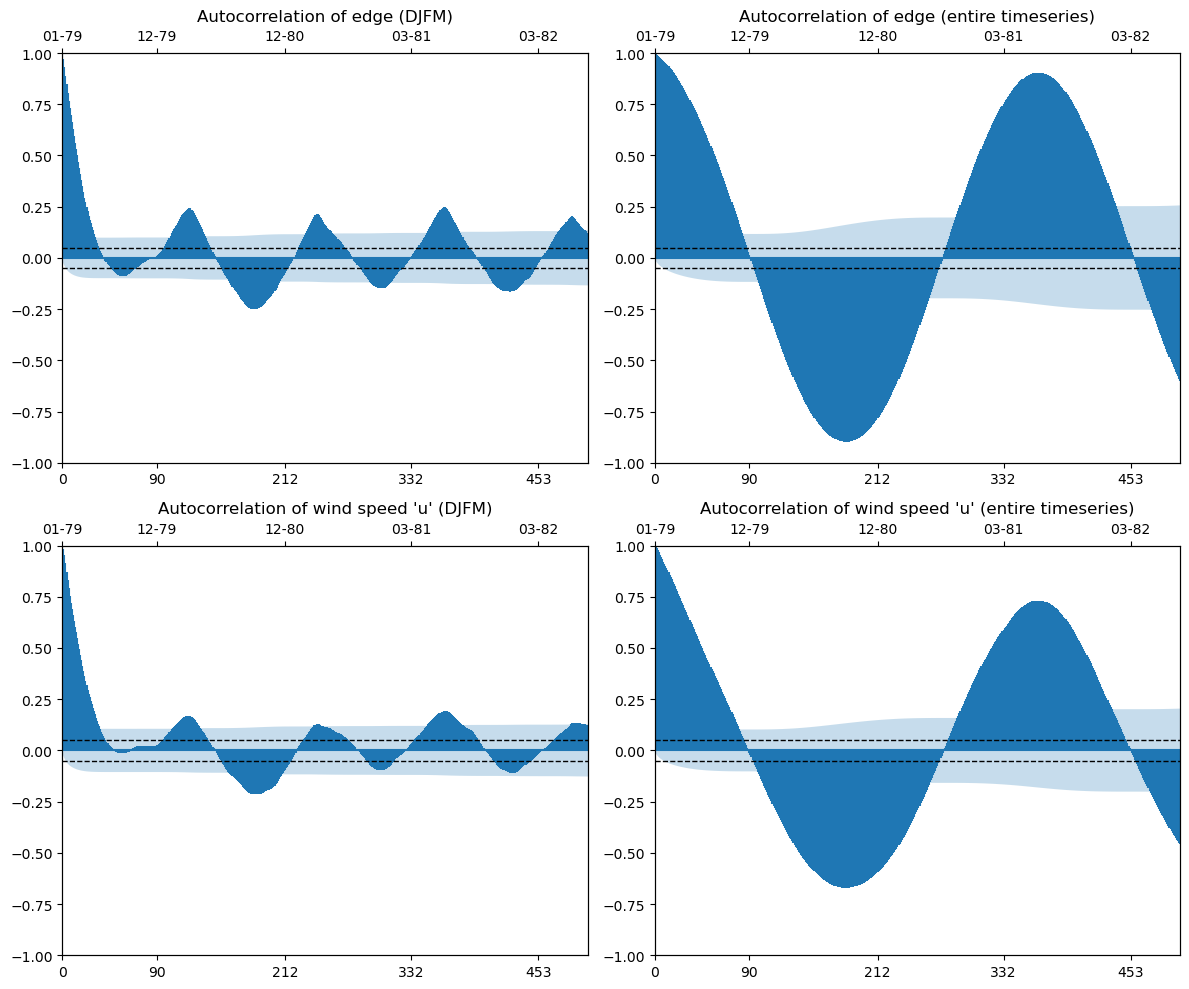

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2, figsize=(12, 10))
ax = ax.flatten()

plot_acf(nwp_geo['scaled_edge'], lags=500, ax=ax[0],  marker=None)
plot_acf(nwp_all['edge'], lags=500, ax=ax[1], marker=None)

plot_acf(nwp_geo['scaled_u'], lags=500, ax=ax[2], marker=None)
plot_acf(nwp_all['u'], lags=500, ax=ax[3], marker = None)

ax[0].set_title('Autocorrelation of edge (DJFM)')
ax[1].set_title('Autocorrelation of edge (entire timeseries)')
ax[2].set_title("Autocorrelation of wind speed 'u' (DJFM)")
ax[3].set_title("Autocorrelation of wind speed 'u' (entire timeseries)")

for i in range(4):
    # 5% boundaries
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    # limit at lag
    ax[i].set_xlim(0, 500)
    # reset xticks to 120days period
    ax[i].set_xticks(positions[:5])
    ax[i].set_xticklabels([str(x) for x in positions[:5]])

    # set dates as second axis
    ax_top = ax[i].twiny()
    ax_top.set_xlim(ax[i].get_xlim())
    ax_top.set_xticks(positions[:5])
    if i%2 == 0:
        labels_dt = nwp_geo.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    else:
        labels_dt = nwp_geo.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)

plt.tight_layout()
plt.show()

The above plots clearly illustrate that a periodic signal is inherent to the edge and wind speed. Hence, it should be filtered, such that the cluster algorithm is able to separate regimes and not phases of the periodic signal.

### Single Spectrum Analysis
The singular spectrum analysis (SSA) can be fundamentally described as a singular value decomposition (SVD) on lagged time series data. It transforms a time series into a multivariate time series using delay coordinates with a sliding window. Deciding the correct window length $M$ is crucial for accurate results. Generally, larger $M$ yield more precise reconstruction, and for periodic signals, $M$ should not significantly exceed the period. Then a SVD is performed on the lagged vectors. The signal can be constructed using the obtained eigenvectors (components).

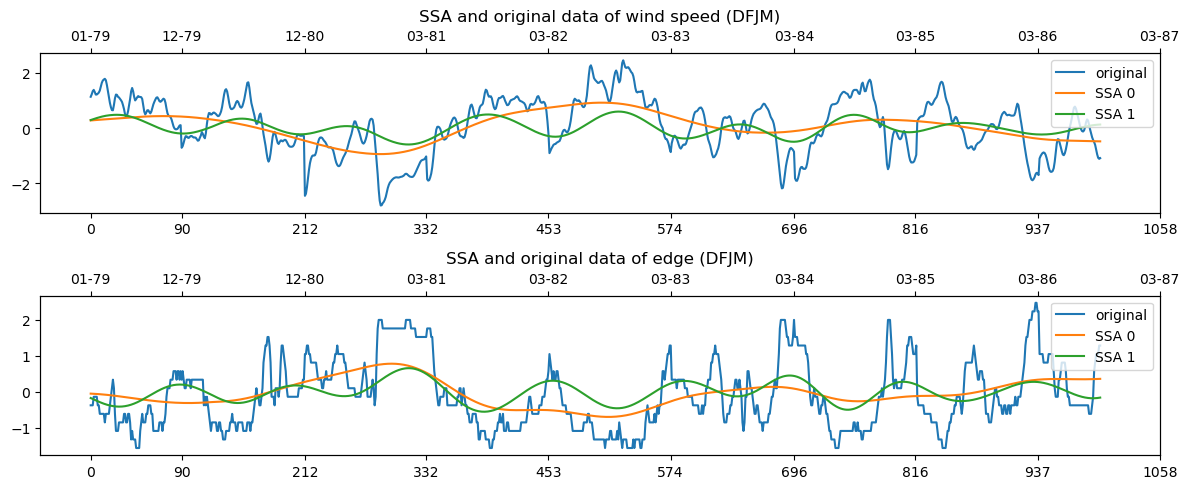

In [7]:
from pyts.decomposition import SingularSpectrumAnalysis

M = 120
ssa = SingularSpectrumAnalysis(window_size=M)
# ssa_area = ssa.fit_transform(nwp_geo['scaled_area'].values.reshape(1,-1))
ssa_edge = ssa.fit_transform(nwp_geo['scaled_edge'].values.reshape(1, -1))
ssa_u = ssa.fit_transform(nwp_geo['scaled_u'].values.reshape(1, -1))

fig, axes = plt.subplots(2, figsize=(12, 5))
# axes[2].set_title('SSA and original data of area (DFJM)')
axes[0].set_title('SSA and original data of wind speed (DFJM)')
axes[1].set_title('SSA and original data of edge (DFJM)')
# axes[2].plot(nwp_geo['scaled_area'][:1000], label='original')
axes[0].plot(nwp_geo['scaled_u'][:1000], label='original')
axes[1].plot(nwp_geo['scaled_edge'][:1000], label='original')
for i in range(2):
    # axes[2].plot(ssa_area[i, :1000], label=f"SSA {i}")
    axes[0].plot(ssa_u[i, :1000], label=f"SSA {i}")
    axes[1].plot(ssa_edge[i, :1000], label=f"SSA {i}")
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
# axes[2].legend(loc='upper right')
for i in range(2):
    # set dates as second axis
    ax_top = axes[i].twiny()
    ax_top.set_xlim(axes[i].get_xlim())
    ax_top.set_xticks(positions[:10])
    axes[i].set_xticks(positions[:10])
    labels_dt = nwp_geo.iloc[positions[:10]]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)

plt.tight_layout()
plt.show()

### Extended Empirical Orthogonal Function
The (extended) empirical orthogonal function (EEOF/EOF) works similar to the SSA, but is more suitable for multivariate data. EEOFs aim to identify propagating patterns across multiple spatial locations over time. They are the eigenvectors of the state vector extended by lagged temporal information for each spatial point. As with SSA, signals can be reconstructed and used for filtering of seasonality.

The EEOF evaluation for wind speed based on NWP data.


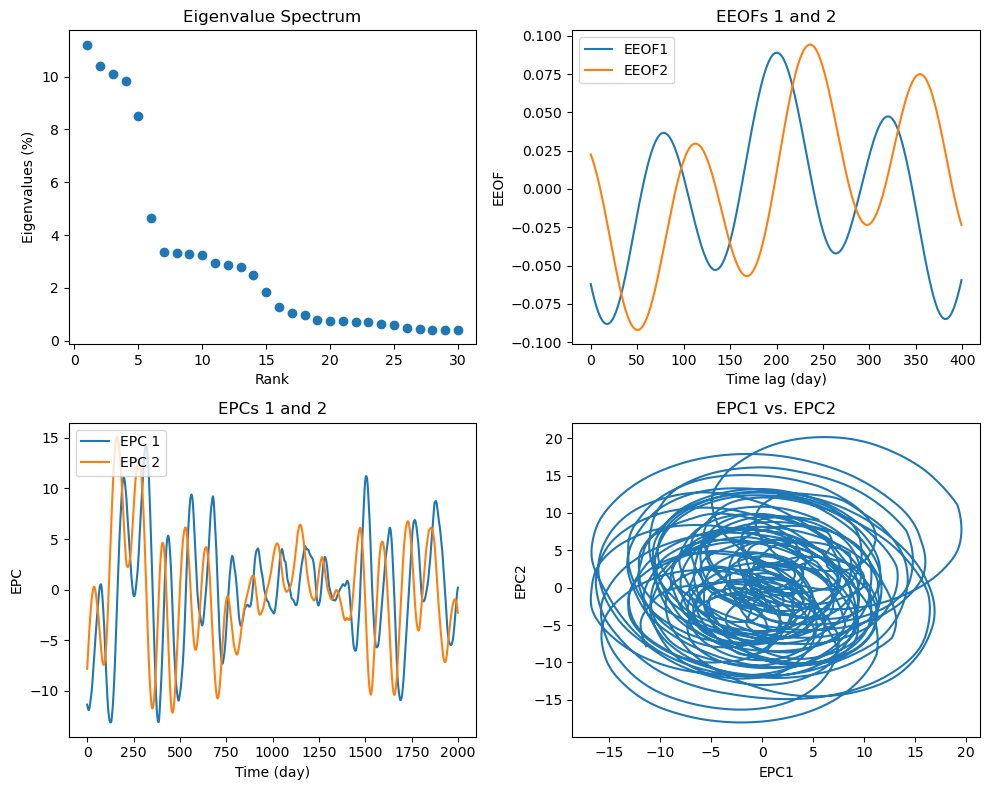

The EEOF evaluation for edge based on NWP data.


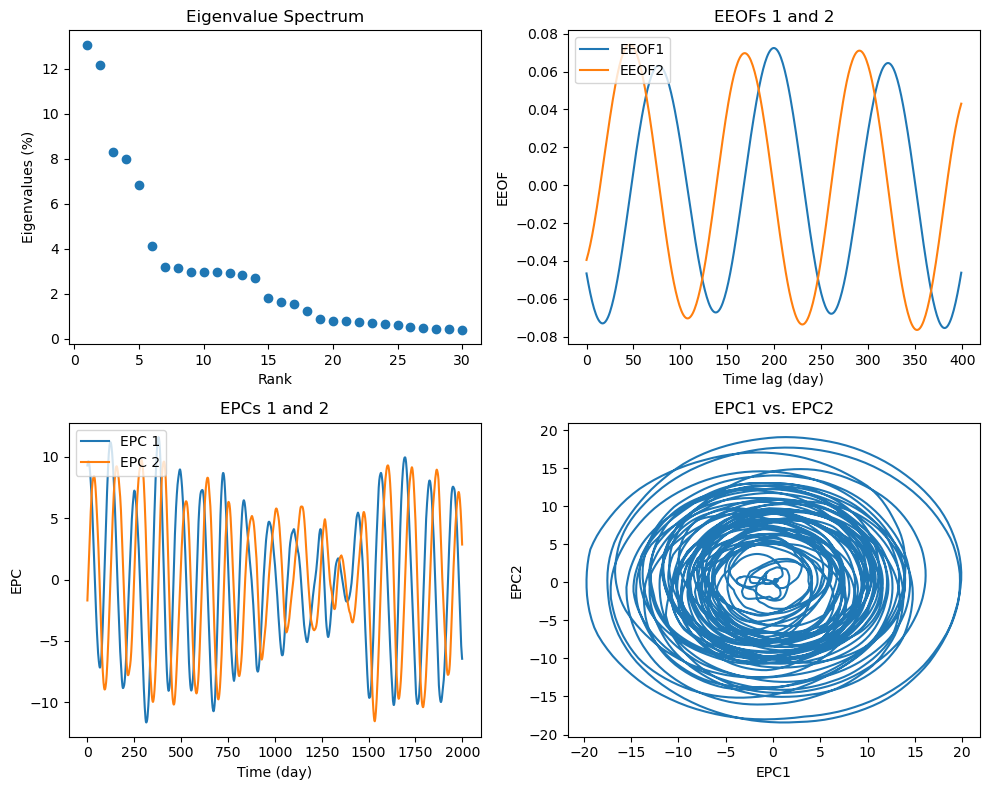

In [8]:
epc_u, eeof_u, expl_var_ratio_u, reconstructed_u, _ = arctic.compute_eeof(nwp_geo['scaled_u'], M=400, n_components=30)
epc_edge, eeof_edge, expl_var_ratio_edge, reconstructed_edge, _ = arctic.compute_eeof(nwp_geo['scaled_edge'], M=400, n_components=30)

from arctic.workflows.demo import plot_eeof
print('The EEOF evaluation for wind speed based on NWP data.')
plot_eeof(epc_u, eeof_u, expl_var_ratio_u)
print('The EEOF evaluation for edge based on NWP data.')
plot_eeof(epc_edge, eeof_edge, expl_var_ratio_edge)

### Filtering
In the above EEOF it can be seen that the wind speed shows 2 wobbly EEOFs, whereas the edge results in 2 sinus function that are differentiated by an offset. This is a clear indicator for a periodic signal. The results from the edge match very closely to the one found by H11 when filtering the area.

The wind speed differs slightly from the results on the ERA5 data. In the ERA5 data the eigenvalue spectrum is dominated by 2 strong leading values and followed by another 2 capturing the majority of the datas variance. Here, the eigenvalues spectrum is dominated by 4 leading eigenvalues, which include roughly 40% of the data variance.

To filter the periodic signal it is reconstructed. H11 used the 4 leading EPCs to reconstruct the signal. Below the reconstruction from 4 leading EPCs as well as SSA components are given. Further the signal is reconstructed from 2, 4 and 30 components for comparison.

It can be easily seen that using to many components completely reconstructs the signal and after filtering only noise would remain. We continue with the selection of the 4 leading components to filter the edge signal and with the 4 leading components to filter the periodic signal of the wind speed. Using 6 components would obscure the signal too much.

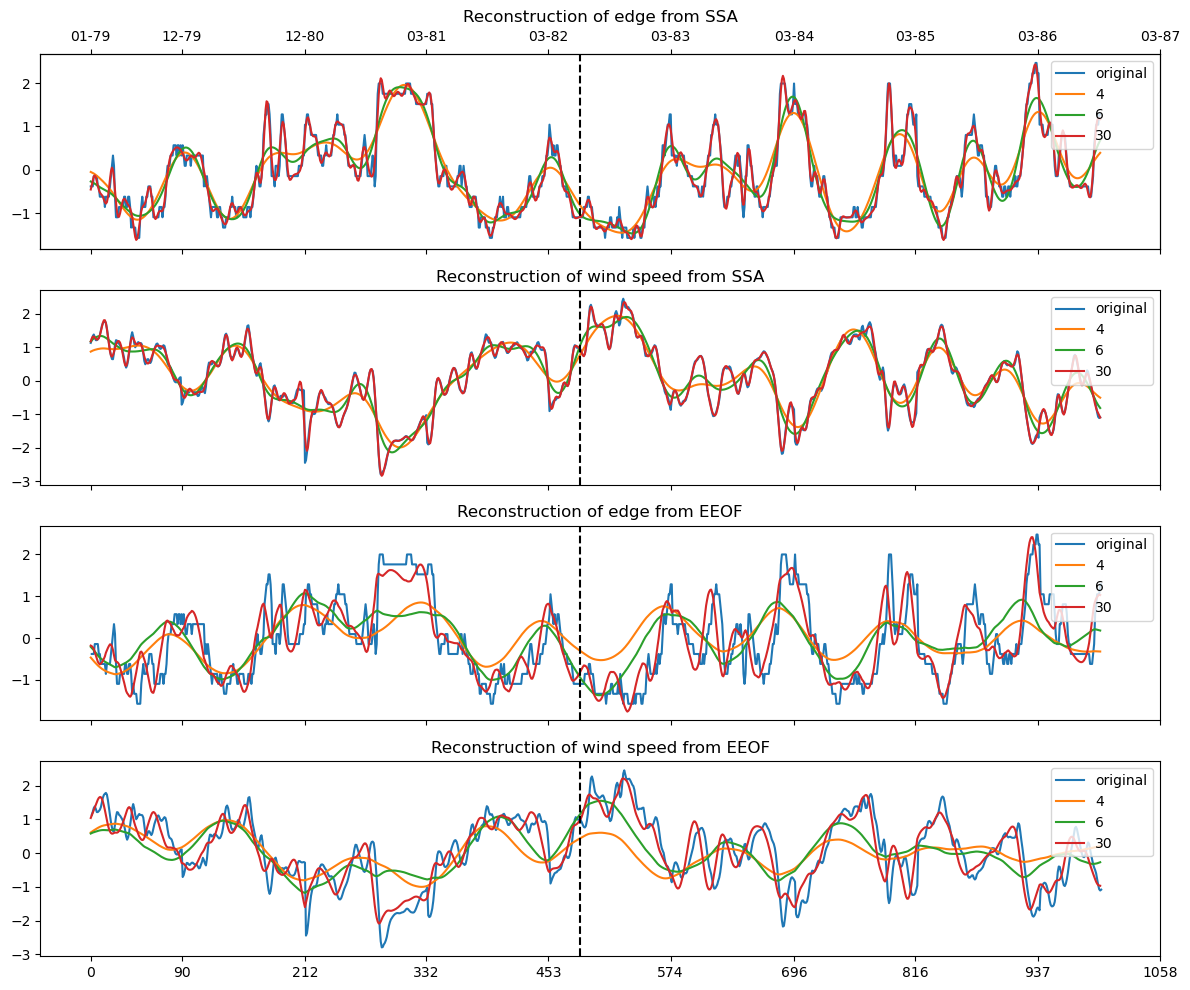

In [9]:
fig, ax = plt.subplots(4, figsize=(12, 10), sharex='all')

ax[0].set_title('Reconstruction of edge from SSA')
ax[1].set_title("Reconstruction of wind speed from SSA")
ax[2].set_title('Reconstruction of edge from EEOF')
ax[3].set_title("Reconstruction of wind speed from EEOF")

ax[0].plot(nwp_geo['scaled_edge'][:1000], label='original')
ax[1].plot(nwp_geo['scaled_u'][:1000], label='original')
ax[2].plot(np.arange(1, 1001), nwp_geo['scaled_edge'][:1000], label='original')
ax[3].plot(np.arange(1, 1001), nwp_geo['scaled_u'][:1000], label='original')
for i in [4, 6, 30]:
    ssa_reconstructed_edge = ssa_edge[:i].sum(axis = 0)
    ssa_reconstructed_u = ssa_u[:i].sum(axis=0)
    _, _, _, eeof_reconstructed_edge, _ = arctic.compute_eeof(nwp_geo['scaled_edge'], M=400, n_components=i)
    _, _, _, eeof_reconstructed_u, _ = arctic.compute_eeof(nwp_geo['scaled_u'], M=400, n_components=i)
    ax[0].plot(ssa_reconstructed_edge[:1000], label=f"{i}")
    ax[1].plot(ssa_reconstructed_u[:1000], label=f"{i}")
    ax[2].plot(eeof_reconstructed_edge[399:1399, 0], label=f"{i}")
    ax[3].plot(eeof_reconstructed_u[399:1399, 0], label=f"{i}")

for i in range(4):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions[:10])
ax[0].set_xticks(positions[:10])
labels_dt = nwp_geo.iloc[positions[:10]]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()

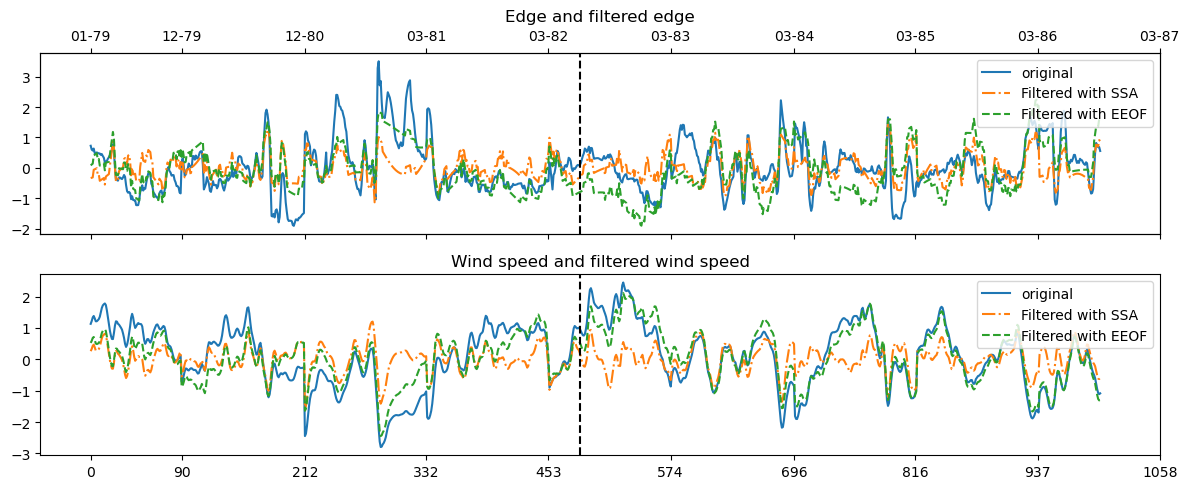

In [10]:
# compute eeof with respective number of components
_, _, _, eeof_reconstructed_edge, _ = arctic.compute_eeof(nwp_geo['scaled_edge'], M=400, n_components=4)
_, _, _, eeof_reconstructed_u, _ = arctic.compute_eeof(nwp_geo['scaled_u'], M=400, n_components=4)

# shorten nwp data by 400 days
nwp_geo = nwp_geo.iloc[:-399, :]

nwp_geo.loc[:, 'ssa_filtered_edge'] = nwp_geo['scaled_edge'] - ssa_edge[:4, :nwp_geo.shape[0]].sum(axis = 0).T
nwp_geo.loc[:, 'ssa_filtered_u'] = nwp_geo['scaled_u'] - ssa_u[:4, :nwp_geo.shape[0]].sum(axis=0).T
nwp_geo.loc[:, 'eeof_filtered_edge'] = nwp_geo['scaled_edge'] - eeof_reconstructed_edge[399:, 0].T
nwp_geo.loc[:, 'eeof_filtered_u'] = nwp_geo['scaled_u'] - eeof_reconstructed_u[399:, 0].T

fig, ax = plt.subplots(2, figsize=(12, 5), sharex='all')
ax[0].set_title('Edge and filtered edge')
ax[0].plot(nwp_geo['scaled_area'][:1000], label='original')
ax[0].plot(nwp_geo['ssa_filtered_edge'][:1000], '-.', label='Filtered with SSA')
ax[0].plot(nwp_geo['eeof_filtered_edge'][:1000], '--', label='Filtered with EEOF')
ax[1].set_title('Wind speed and filtered wind speed')
ax[1].plot(nwp_geo['scaled_u'][:1000], label='original')
ax[1].plot(nwp_geo['ssa_filtered_u'][:1000], '-.', label='Filtered with SSA')
ax[1].plot(nwp_geo['eeof_filtered_u'][:1000], '--', label='Filtered with EEOF')

for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions[:10])
ax[0].set_xticks(positions[:10])
labels_dt = nwp_geo.iloc[positions[:10]]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()

## Gap statistic
The performance of clustering algorithm depends severely on the right number of clusters as input. The determination of the right number of cluster $k$ is subject to a lot of research, as fitting models is computationally expensive and more elegant ways than simply testing different $k$ are required. Further unsupervised clustering has no notion of wrong or right, but requires different measures to evaluate a models quality. Most methods define a measure of similarity, which should be maximized in clusters and minimized between clusters. Consequently, dissimilarity is defined vice versa. Then the similarity or dissimilarity is compared for different values of $k$.

The gap statistic introduced by Tibshirani et al. (2001) bases on the idea to compare the within cluster dispersion of the actual data to a null reference. The null reference is usually generated by a homogeneous Poisson point process (HPPP).

To compute the within cluster dispersion, the pairwise squared distances between all data points in a cluster $C_m, m=1, ..., k$ are computed by

$$D_m = \sum_{i,j \in C_m} \|x_i- x_j\|^2 = 2n_m \sum_{i=1}^{n_m} \|x_i- \mu_m\|^2$$

with $|C_m| = n_m$ being the size of the $m$th cluster.

Some implementations use the distance $\|x_i - c_m\|$, i.e. the distance of a data point $x_i$ to its corresponding cluster center $c_m=\mu_m$. This is only applicable in clustering algorithms that have some notion of centers such as k-means. For clustering methods without such centers such as hierarchical clustering, the gap statistic is more precise using the above notation instead of calculating centers manually.

In the next step, $D_m$ is averaged to obtain
$$W_k = \sum_{m=1}^{k} \frac{D_m}{2n_m}$$
The sum of squared distances to the center of a cluster is the same as $W_k$ as long there are no sample weights.

Finally, the gap statistic for each $k$ is computed by the difference between the *within dispersion index* of the data, $log(W_k)$,  and that expected from the generated reference $log(W_k^*)$.
$$G(k) = E[log(W_k^*)] - log(W_k)$$


Here, $E(\cdot)$ is the expectation as usually defined. A Monte Carlo simulation is used to generate $N$ samples of $log(W_k^*)$, where each $W_k^*$ is based on the same number of points as the original data. Additionally, the standard deviation $s_k^*$ is computed and used to account for the simulation error in $E[log(W_k^*)]$ with the inflated standard deviation $s_k = s_k^*\sqrt{1+\frac{1}{N}}$. Finally, the optimal $k_{opt}$ is determined by the smallest $k$ such that

$$
	G(k) \geq G(k+1) - s_{k+1}
$$

Tibshirani et al. conducted a comparative analysis demonstrating that the gap statistic is a robust method for estimating the number of clusters. Their findings indicate that, for elongated clusters, the gap statistic yields better results with a null reference aligned to the data's principle components. In contrast, using a simple uniform distribution leads to inferior results. Overall, the underlying distribution of data does not influence the results of the gap statistic, making it more robust than other methods.

The performance of the gap statistic deteriorates in high-dimensional settings due to computational costs. It is also prone to underestimation the optimal $k$ in settings with many clusters. The underestimation vanishes with increasing dimensionality.

H11 focused on the Gap statistic which is also implemented below. Additionally, elbow and silhouette methods are considered and compared to the results of the gap statistic.

## Hierarchical Clustering
Hierarchical clustering is a family of clustering methods that focuses on building nested clusters. This is achieved by merging or splitting them successively. The hierarchy can be represented in a so-called dendrogram, i.e. a tree, where the root contains all samples and each leaf represents a samples. Leaves next to each other correspond to similar samples. H11 does not further specify what hierarchical clustering algorithm is used. Here, agglomorative clustering was used as an adaption.

Agglomerative clustering uses a bottom up approach, i.e. each sample represent its own cluster and is successively merged with the most similar cluster. The linkage describes the merging strategy and computation of distance between clusters. The default is $complete$ as determined in H11 to avoid spheroidal or chaining clusters and distance means the Euclidean distance. Below an overview of some linkage methods is given.

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

The code cells below might take a few minutes to compute due to the computationally expensive operations of training a model and computing the corresponding metric for evaluation.


In [11]:
k_max = 10
gap_ar_latcent = arctic.gap_statistic(nwp_geo[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = arctic.gap_statistic(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area_edge = arctic.gap_statistic(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge']], k_max=k_max, n_replicates=15)
gap_ar_latcent_u = arctic.gap_statistic(nwp_geo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max, n_replicates=15)

In [12]:
elbow_ar_latcent = arctic.elbow_method(nwp_geo[['scaled_ar', 'scaled_latcent']], k_max=k_max)
elbow_ar_latcent_area = arctic.elbow_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
elbow_ar_latcent_area_edge = arctic.elbow_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge']], k_max=k_max)
elbow_ar_latcent_u = arctic.elbow_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

In [13]:
silhouette_ar_latcent = arctic.silhouette_method(nwp_geo[['scaled_ar', 'scaled_latcent']], k_max=k_max)
silhouette_ar_latcent_area = arctic.silhouette_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
silhouette_ar_latcent_area_edge = arctic.silhouette_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge']], k_max=k_max)
silhouette_ar_latcent_u = arctic.silhouette_method(nwp_geo[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

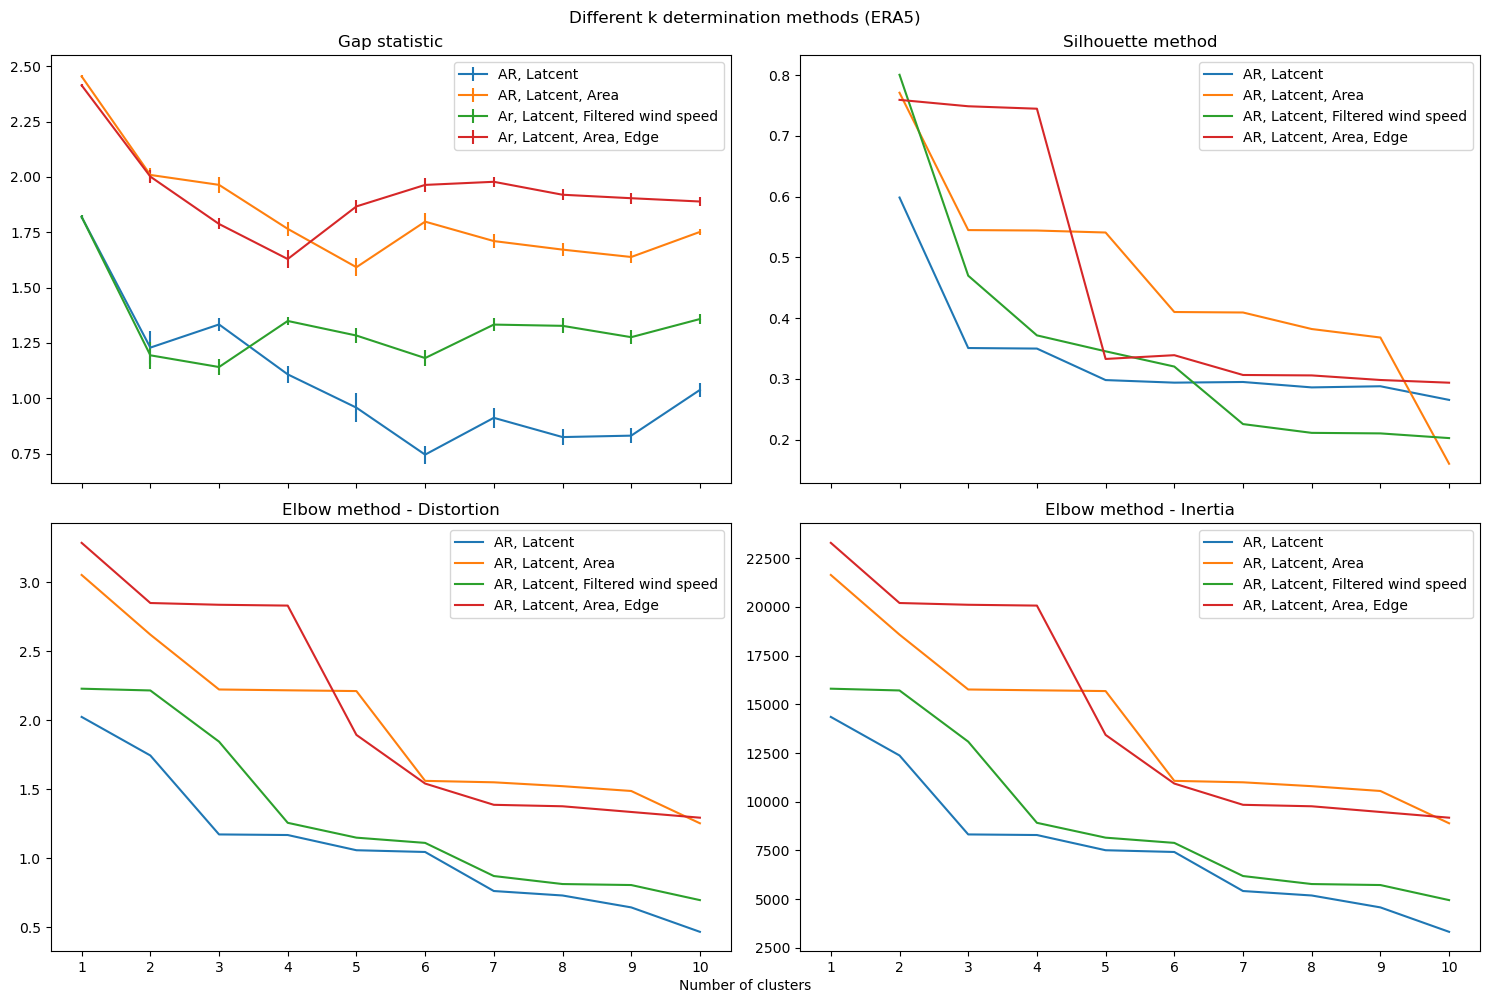

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex='all')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent[:, 0], yerr=gap_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_area[:, 0], yerr=gap_ar_latcent_area[:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_u[:, 0], yerr=gap_ar_latcent_u[:, 1], label='Ar, Latcent, Filtered wind speed')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_area_edge[:, 0], yerr=gap_ar_latcent_area_edge[:, 1], label='Ar, Latcent, Area, Edge')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend(loc='upper right')

ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent[0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[0], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[0], label='AR, Latcent, Filtered wind speed')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_area_edge[0], label='AR, Latcent, Area, Edge')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend(loc='upper right')

ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent[1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[1], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[1], label='AR, Latcent, Filtered wind speed')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_area_edge[1], label='AR, Latcent, Area, Edge')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend(loc='upper right')

ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_u, label='AR, Latcent, Filtered wind speed')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_area_edge, label='AR, Latcent, Area, Edge')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend(loc='upper right')

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, k_max+1))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.show()

In [15]:
print("Optimal number of clusters by each method: ")
p_1, p_2, p_3, p_4 = 1,1,1,1
for k in range(1, 10):
    if p_1 and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1) # index starts at 0, k starts at 1
        p_1=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_4 and (gap_ar_latcent_area_edge[k][0] >= gap_ar_latcent_area_edge[k+1][0] - gap_ar_latcent_area_edge[k+1][1]):
        print("Gap statistic (AR, Latcent, Area, Edge): ", k+1)
        p_4 = 0
    if p_3 and (gap_ar_latcent_u[k][0] >= gap_ar_latcent_u[k+1][0] - gap_ar_latcent_u[k+1][1]):
        print("Gap statistic (AR, Latcent, filtered wind speed): ", k+1)
        p_3=0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area, Edge): ", pd.DataFrame(silhouette_ar_latcent_area_edge).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered wind speed): ", pd.DataFrame(silhouette_ar_latcent_u).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent, Area):  2
Gap statistic (AR, Latcent, Area, Edge):  2
Gap statistic (AR, Latcent, filtered wind speed):  2
Gap statistic (AR, Latcent):  3
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, Area, Edge):  2
Silhouette method (AR, latcent, filtered wind speed):  2


### Optimal number of clusters
The gap statistic suggest that the data lacks inherent clustering structure, consistently favouring $k=1$. The silhouette method partially supports that.

However, when assuming that at least some structure exists and evaluating $k > 1$, all methods indicate $k_{opt} = 3$ when clustering based on ar and latcent. The model based on ar, latcent and the filtered wind speed clearly indicates $k_{opt} = 4$, exception is the silhouette method. The silhouette methods favours clearly separated clusters of the same density and size. In the analysis of ERA5 reanalysis data, it showed that a very sparse large cluster emerged from the data. Should this occur in the NWP data as well, the silhouette method might be underestimating the optimal number of clusters.

In contrast, the introduction of the area computed from $Z10$ leads to ambiguity. The gap statistic and silhouette method indicate no structure in the data. Though the gap statistic has local maxima at $k=6$ with ar, latcent, and area, and $k=7$, when the edge is added. It is a known disadvantage of the gap statistic, that it will select the first local maxima as optimal $k$, even though another $k$ might be more suitable. The elbow methods support these results.

Tabular summary of $k_o{opt}$ for each method:

| Used features           | Gap statistic | Silhouette  | Elbow (Distortion) | Elbow (Inertia) | $k_{opt}$ |
|-------------------------|---------------|-------------|--------------------|-----------------|-----------|
| AR, latcent             | 1 or 3        | 3           | 3                  | 3               | 3         |
| AR, latcent, wind speed | 1 or 4 or 7   | 2           | 4                  | 4               | 4         |
| AR, latcent, area       | 1, 2, 3 or 6  | 2 or 3 or 6 | 6                  | 6               | 6         |
| AR, latcent, area, edge | 1 or 7        | 2 or 3 or 4 | 6 or 7             | 6 or 7          | 7         |

For the remainder of the analysis $k_{opt}$ as indicated above is adopted, based on convergence of the elbow method, gap statistic and silhouette method.

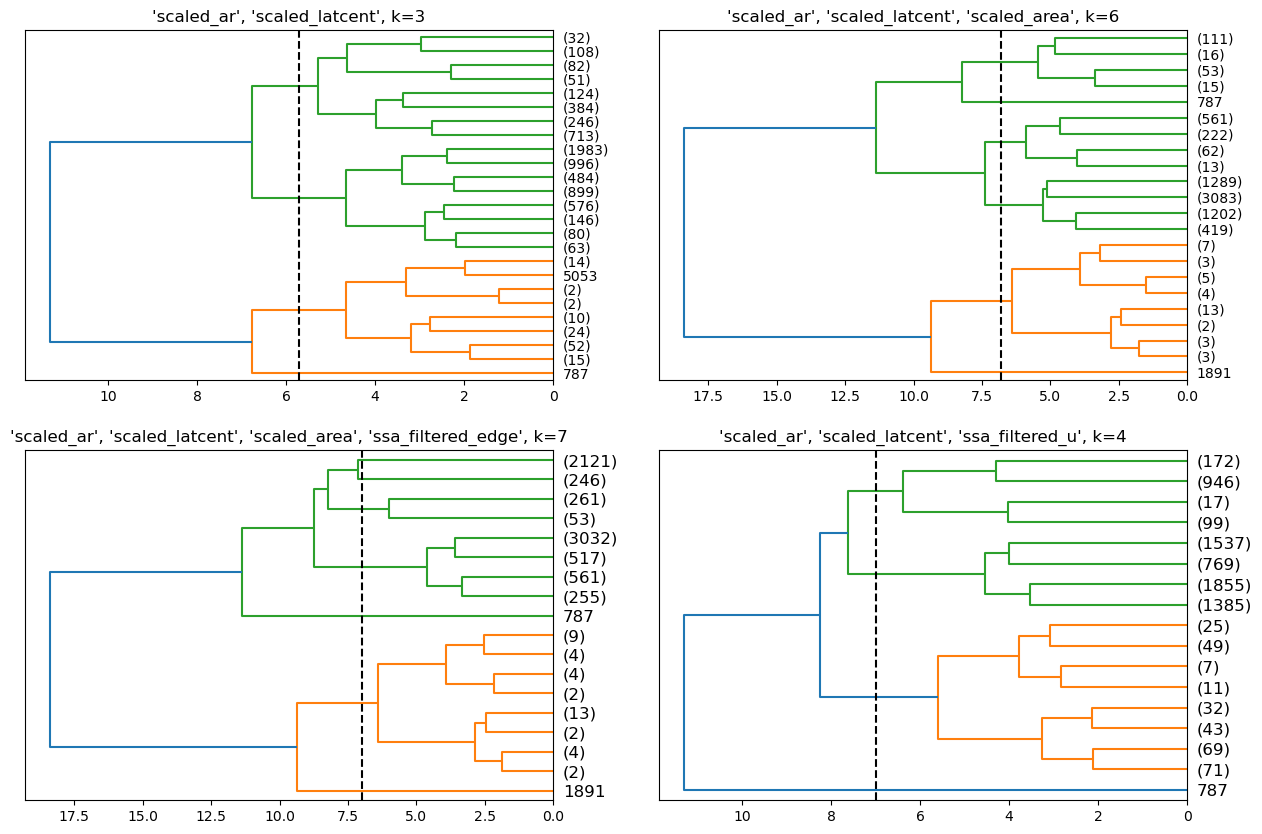

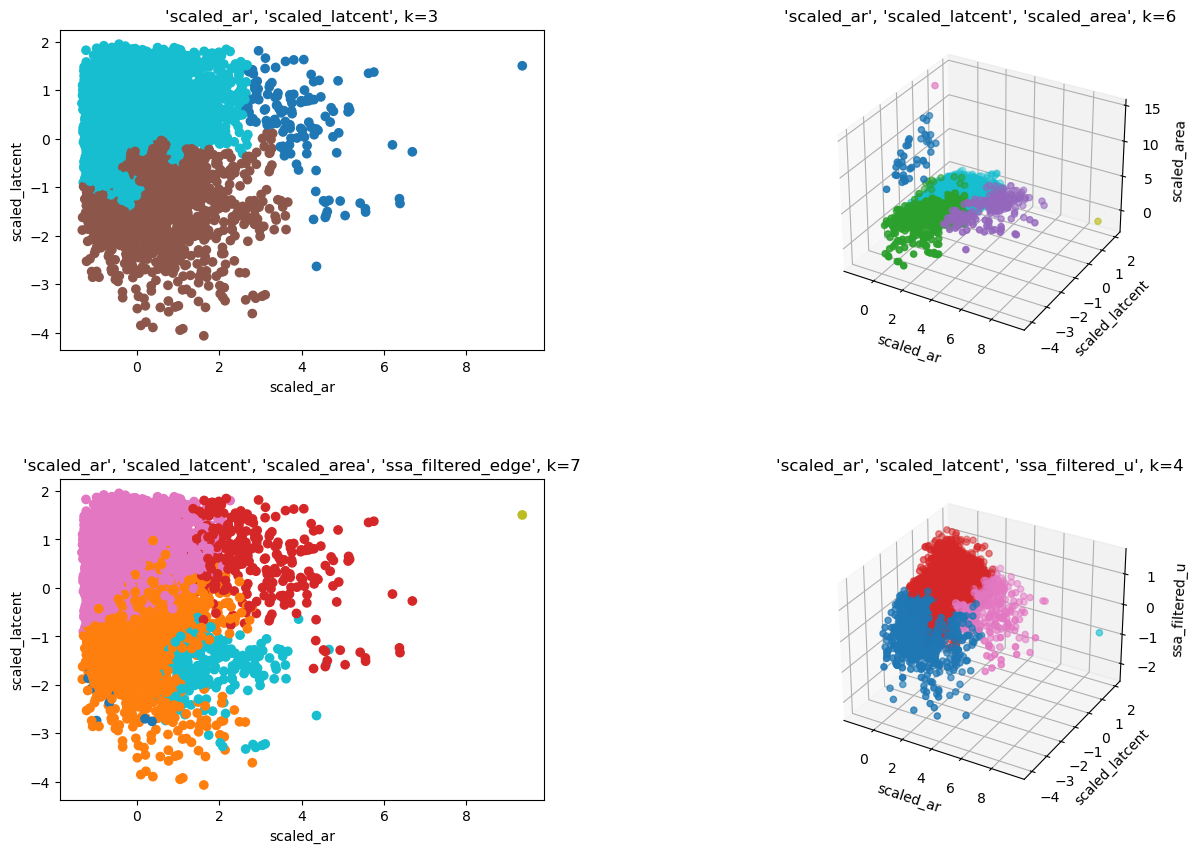

In [16]:
from sklearn import clone
from sklearn.cluster import AgglomerativeClustering

features_kopt = [{'features' : ['scaled_ar', 'scaled_latcent'], 'k_opt' : 3, 'line':5.7},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area'], 'k_opt' : 6, 'line':6.8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge'], 'k_opt' : 7, 'line':7},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_u'], 'k_opt' : 4, 'line':7}]


Y = []
base_model = AgglomerativeClustering(linkage='complete', compute_distances=True)

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    model = clone(base_model)
    model.set_params(n_clusters = feat_k['k_opt'])
    model.fit(nwp_geo[feat_k['features']])
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
    arctic.plot_dendrogram(model, truncate_mode='level', p=4, direction='LR')
    ax.axvline(feat_k['line'], ls='--', color='black')
    y_pred = model.labels_.astype(int)
    Y.append(y_pred)
plt.show()

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    if len(feat_k['features']) == 3:
        ax = fig.add_subplot(2,2,idx+1, projection='3d')
        ax.scatter(nwp_geo[feat_k['features']].iloc[:, 0],
                   nwp_geo[feat_k['features']].iloc[:, 1],
                   nwp_geo[feat_k['features']].iloc[:, 2],
                   c=Y[idx], cmap='tab10')
        ax.set_facecolor((0, 0, 0, 0))
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
        ax.set_zlabel(feat_k['features'][2])
    else:
        ax = fig.add_subplot(2,2, idx+1)
        ax.scatter(nwp_geo[feat_k['features']].iloc[:, 0],
                   nwp_geo[feat_k['features']].iloc[:, 1],
                   c=Y[idx], cmap='tab10')
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
plt.show()

# Results
Below the relative and absolute distribution of physical measurements for each cluster is visualized. The goal is to identify and assign clear characteristics for each cluster. It is expected to clearly recognize a split cluster (S) that corresponds to the threshold based assignment of split. Additionally, a displaced cluster (D) is expected that should be characterized by significantly different distribution of latcent. The later may be hard to distinguish as split events are usually accompanied by displacement.

## Statistical Profiles of Clusters
### Aspect ratio and Latcent
The majority of samples falls into Class **2**, which does not show any remarkable characteristics. Class **1** exhibits a significantly larger ar than the other two clusters, which does have a minimum of $ar_{scaled}=2.655$ (resp. $ar = 2.257$). Class **0** displays a significantly smaller latcent, barely exceeding the average latcent at 0. Consequently, classes are assigned as follows:

**0** &rarr; S (Split)<br>
**1** &rarr; U (Undisturbed/normal state)<br>
**2** &rarr; D (Displaced)

This is the only model that did not create clusters with only one sample.

Averages per class and features:
              scaled_ar  scaled_latcent        ar
y_ar_latcent                                     
D              0.387689       -1.264053  1.541393
S              3.996577        0.326302  2.679438
U             -0.219893        0.390108  1.349796


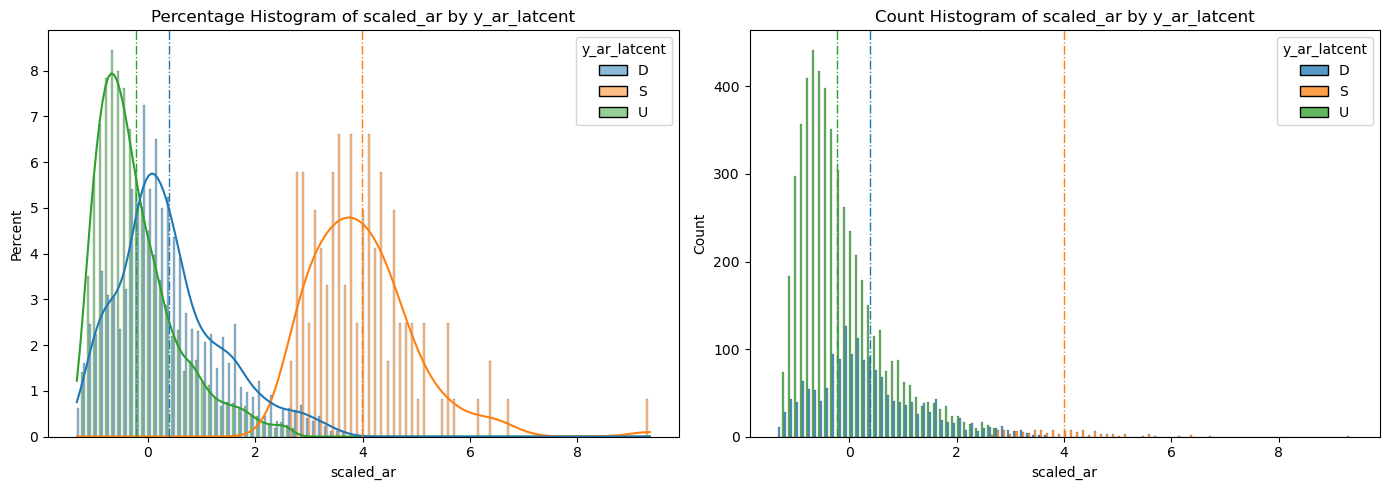

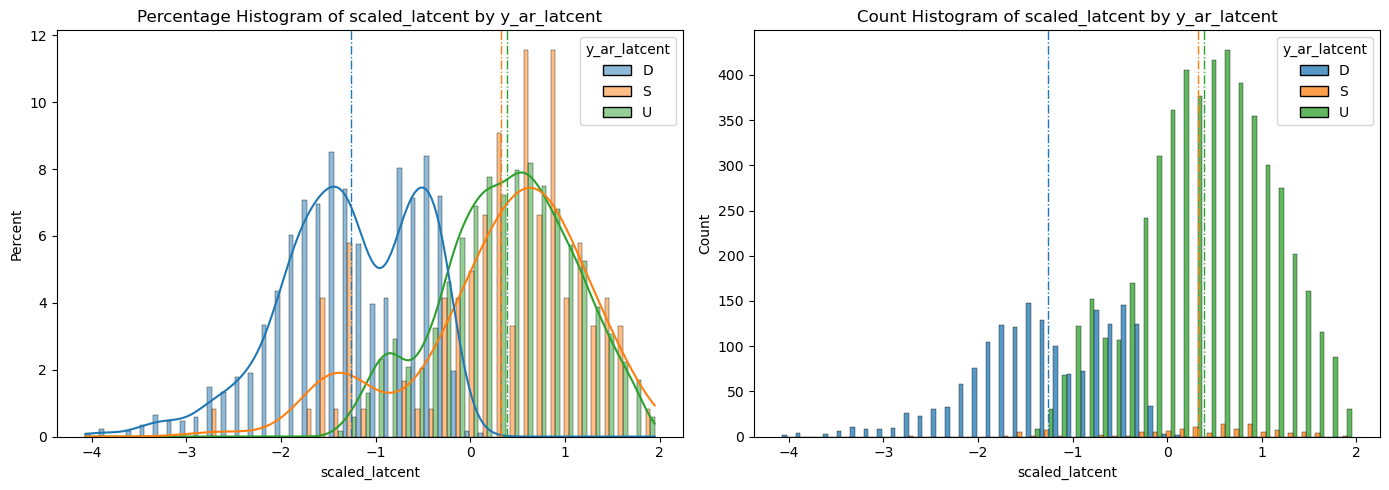

In [17]:
from arctic.workflows.demo import plot_hist_per_class

y_names = ['y_ar_latcent', 'y_ar_latcent_scArea', 'y_ar_latcent_area_edge', 'y_ar_latcent_u']
nwp_geo[y_names] = pd.DataFrame(Y).T

nwp_geo['y_ar_latcent'] = nwp_geo['y_ar_latcent'].replace({0: 'S', 1:'D', 2:'U'})
print("Averages per class and features:")
print(nwp_geo[['y_ar_latcent', 'scaled_ar', 'scaled_latcent', 'ar']].groupby(['y_ar_latcent']).mean())

plot_hist_per_class(nwp_geo, # data
                    features_kopt[0], # information about used feature and k_opt
                    'y_ar_latcent') # column name with y values


### Aspect ratio, latcent and wind speed
When adding the wind speed as a proxy for the area in H11, the distinction between the above classes becomes clearer. The majority of samples falls into Class **1**, which is characterised by relatively average values for latcent and ar. Interestingly, it has higher values for the filtered wind speed than the other two classes. Class **2** exhibits a significantly larger ar and class **0** displays a significantly smaller latcent. Assigning the S, D, and U respectively, it matches the observation that **2** and **0** have similar distributions for the wind speed, but generally weaker winds than **1**. Split and disturbed events usually result in weakened westerlies or even their reversal. Consequently, classes are assigned as follows:

**0** &rarr; D (Displaced)<br>
**1** &rarr; S (Split)<br>
**2** &rarr; U (Undisturbed/normal state)

The fourth class which was detected when determining the optimal k consists of one sample with an extremely large aspect ratio ($ar=4.37, ar_{scaled} = 9.35$)and is therefore marked as **E** for extrema. It should be classified into the split cluster, but due to scaling its distance to the other clusters is enlarged.

Averages per class and features:
                scaled_ar  scaled_latcent  ssa_filtered_u        ar
y_ar_latcent_u                                                     
D                0.145754       -1.598618       -0.472367  1.465100
E                9.353130        1.502202       -0.678404  4.368600
S                2.828270        0.323412       -0.272696  2.311018
U               -0.189092        0.315728        0.120815  1.359508
y_ar_latcent_u
D    1234
E       1
S     307
U    5546
dtype: int64


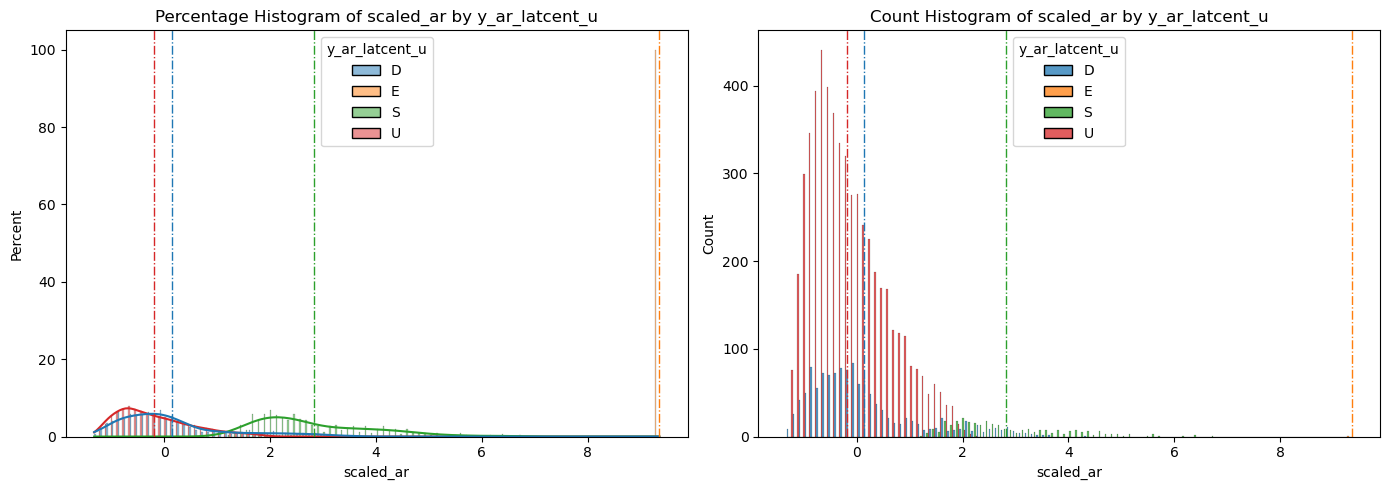

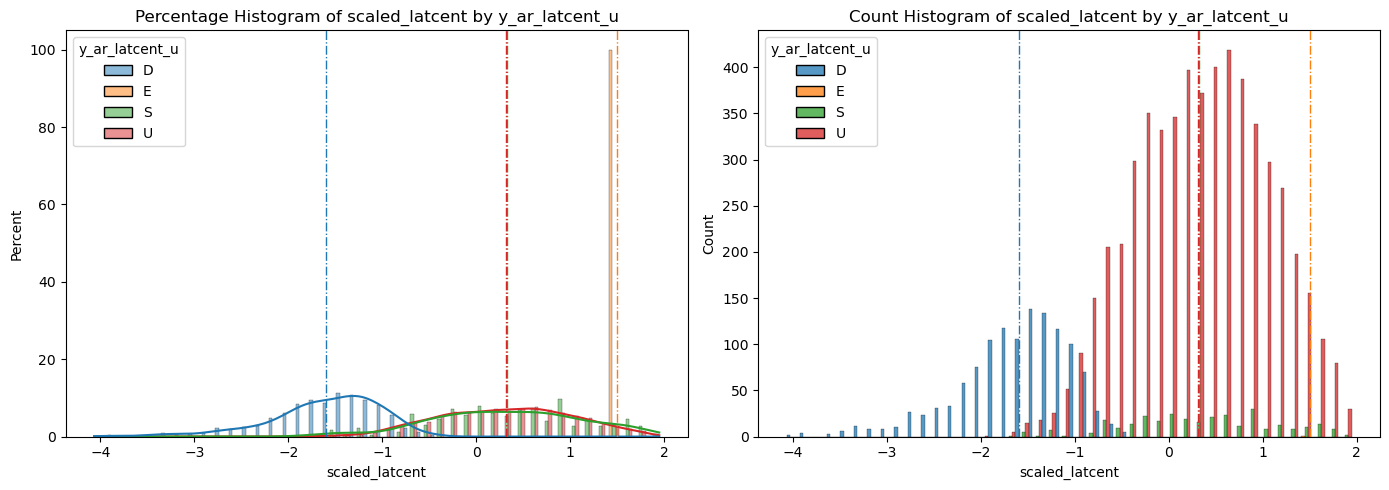

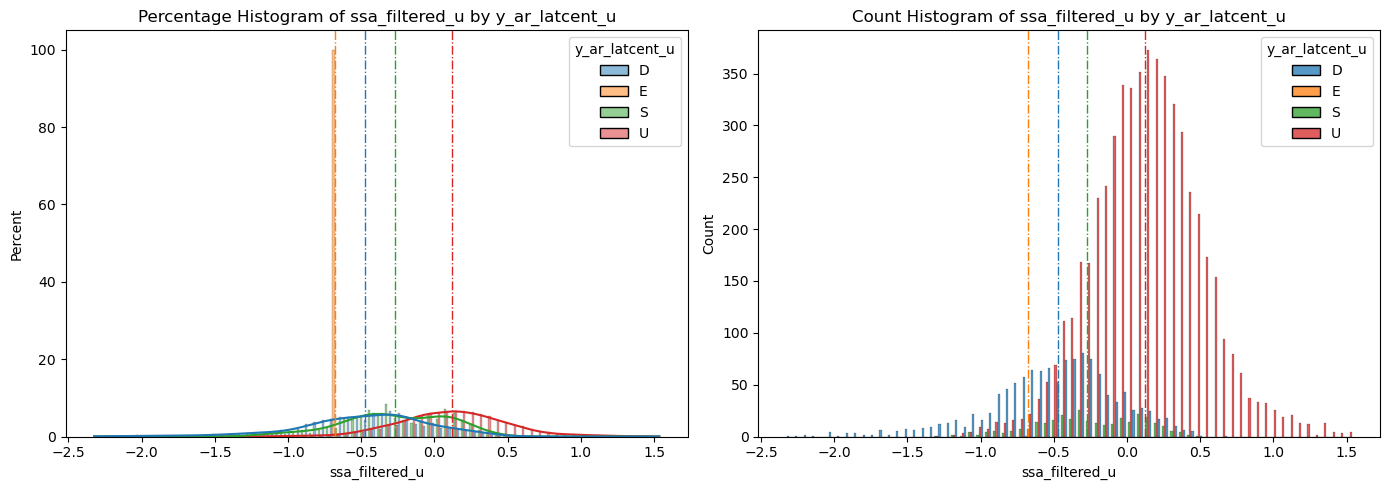

In [18]:
nwp_geo['y_ar_latcent_u'] = nwp_geo['y_ar_latcent_u'].replace({0:'D', 1:'U', 2:'S', 3:'E'})
print("Averages per class and features:")
print(nwp_geo[['y_ar_latcent_u', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_u', 'ar']].groupby(['y_ar_latcent_u']).mean())
print(nwp_geo[['y_ar_latcent_u', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_u']].groupby(['y_ar_latcent_u']).size())
plot_hist_per_class(nwp_geo, # data
                    features_kopt[3], # information about used feature and k_opt
                    'y_ar_latcent_u') # column name with y values

### Aspect ratio, latcent, and vortex area
Adding the area computed with at 10hPa geopotential height, added some ambiguity to the interpretation as split, displaced and undisturbed. Additionally, the optimal k was determined as 6. As in the previous model, a single example was extracted as its own cluster. Here, class **3** is a sample with an extremely large area, and class **4** a sample with an extremely large aspect ratio.
The remaining clusters could be characterized as split (class **2**) by the distribution of the aspect ratio. Class **0** is described as large displaced vortex with small latcent values and significantly larger areas. This cluster seems to correspond closely to the identified **L** cluster in the full analysis in the other notebook. The second displaced cluster contains the majority of displaced events, and also has a larger aspect ratio than most samples. Last, but not least, class **5** is characterized by relatively average values in all features. Hence, marked as undisturbed.

Using ar, latcent, and area:<br>
**0** &rarr; L (Large area and slightly displaced)<br>
**1** &rarr; D (Displaced)<br>
**2** &rarr; S (Split)<br>
**3** &rarr; E_area (Extrema with large area, single sample)<br>
**4** &rarr; E_ar (Extrema with large aspect ratio, single sample)<br>
**5** &rarr; U (Undisturbed/normal state)<br>

Averages per class and features:
                     scaled_ar  scaled_latcent  scaled_area
y_ar_latcent_scArea                                        
D                     0.554252       -1.676987     1.144541
E_ar                  9.353130        1.502202    -0.419060
E_area               -1.198489        0.635199    14.618168
L                    -0.629692       -1.313286     8.363038
S                     3.513516       -0.188912     1.161740
U                    -0.189365        0.234475    -0.246908
y_ar_latcent_scArea
D          858
E_ar         1
E_area       1
L           40
S          195
U         5993
dtype: int64


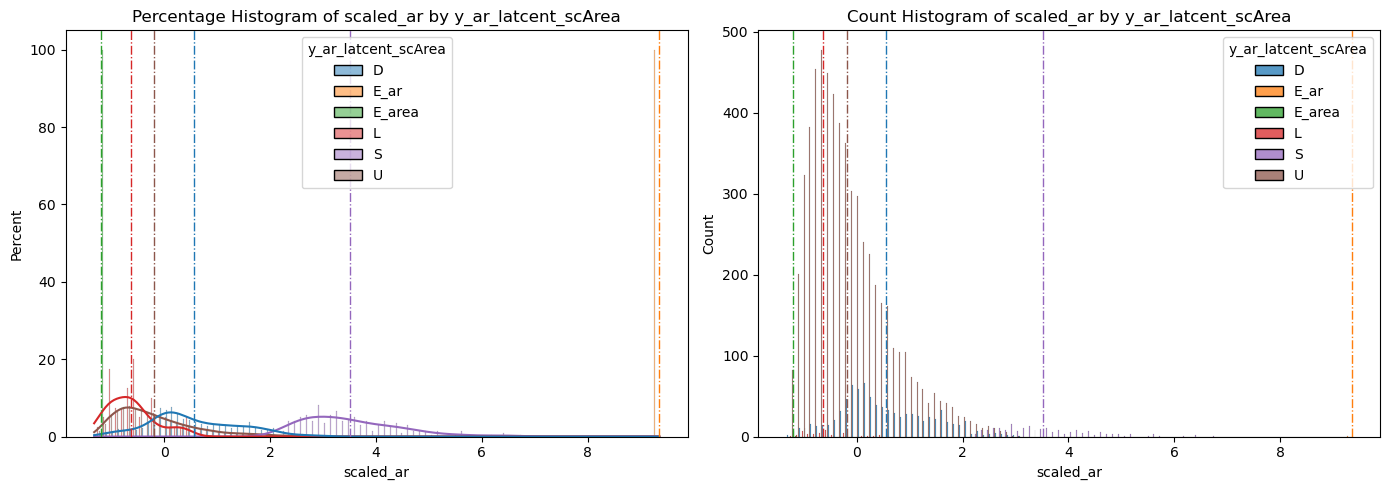

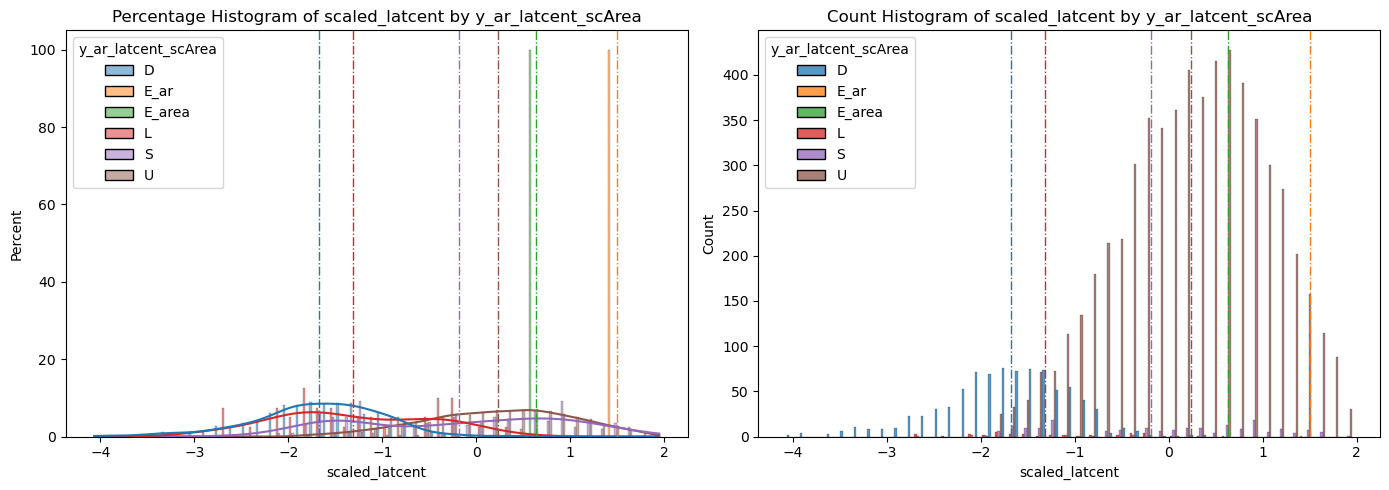

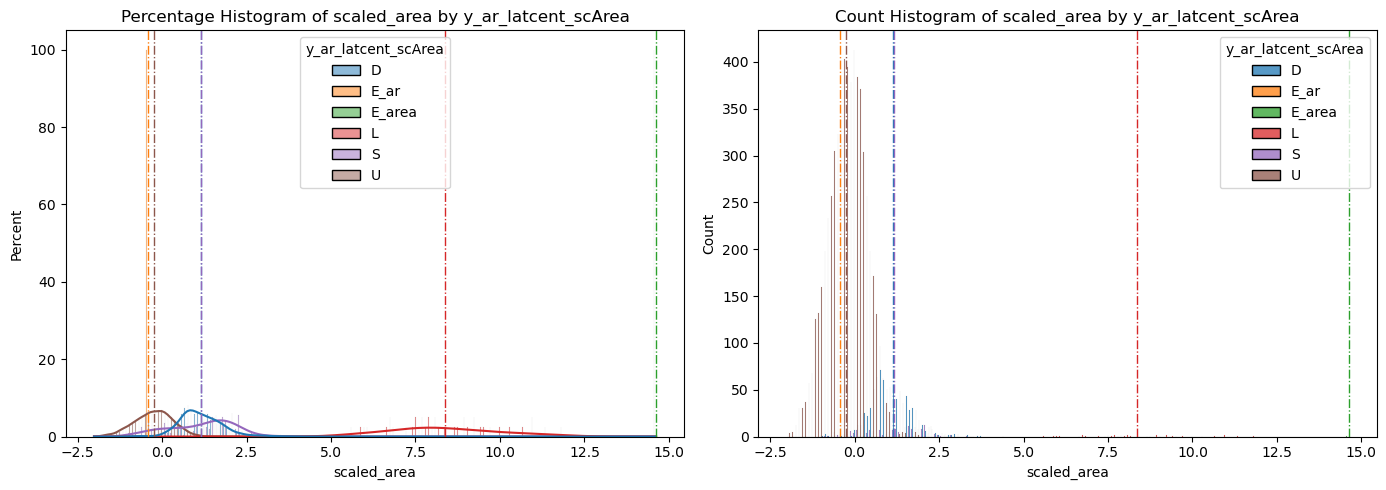

In [19]:
nwp_geo['y_ar_latcent_scArea'] = nwp_geo['y_ar_latcent_scArea'].replace({0: 'L', 1:'D', 2:'S', 3 : 'E_area', 4 : 'E_ar', 5 : 'U'})
print("Averages per class and features:")
print(nwp_geo[['y_ar_latcent_scArea', 'scaled_ar', 'scaled_latcent', 'scaled_area']].groupby(['y_ar_latcent_scArea']).mean())
print(nwp_geo[['y_ar_latcent_scArea', 'scaled_ar', 'scaled_latcent', 'scaled_area']].groupby(['y_ar_latcent_scArea']).size())

plot_hist_per_class(nwp_geo, # data
                    features_kopt[1], # information about used feature and k_opt
                    'y_ar_latcent_scArea') # column name with y values

### Aspect ratio, latcent, area and edge

When the edge was added as additional information, even more clusters emerge and the optimal k was found to be 7.  Again, extrema where assigned their own classes, class **3** is a sample with an extremely large area, and class **5** contains a sample with an extremely large aspect ratio.
The remaining clusters are characterized as split (class **2**) by the distribution of the aspect ratio. Class **0** is described by vortices with small latcent values and significantly larger areas. This cluster seems to correspond closely to the identified **L** cluster in the full analysis in the other notebook. Class **1** contains roughly a third of the data, and seems to correspond to the displaced events as indicated by the latcent distribution. Further displaced vortices are contained in class **6**, though class **6** has an aspect ratio, that is above average. Hence, it is assigned **DS** for displaced and split state. Finally, class **4** represents the undisturbed state.

Using ar, latcent, area, and edge:<br>
**0** &rarr; L (Large)<br>
**1** &rarr; DI (Displaced I)<br>
**2** &rarr; S (Split)<br>
**3** &rarr; E_area (Extrema with large area, single sample)<br>
**4** &rarr; U (Undisturbed/normal state)<br>
**5** &rarr; E_ar (Extrema with large aspect ratio, single sample)<br>
**6** &rarr; DS (Displaced and split)<br>

Averages per class and features:
                        scaled_ar  scaled_latcent  scaled_area  \
y_ar_latcent_area_edge                                           
D                        0.056369       -0.971119     0.520443   
DS                       1.846028       -1.623172     1.600212   
E_ar                     9.353130        1.502202    -0.419060   
E_area                  -1.198489        0.635199    14.618168   
L                       -0.629692       -1.313286     8.363038   
S                        2.768808        0.577105     0.533337   
U                       -0.324689        0.505693    -0.443562   

                        ssa_filtered_edge  
y_ar_latcent_area_edge                     
D                                0.293738  
DS                               0.689709  
E_ar                             0.398345  
E_area                           0.891305  
L                                0.775128  
S                                0.249471  
U                   

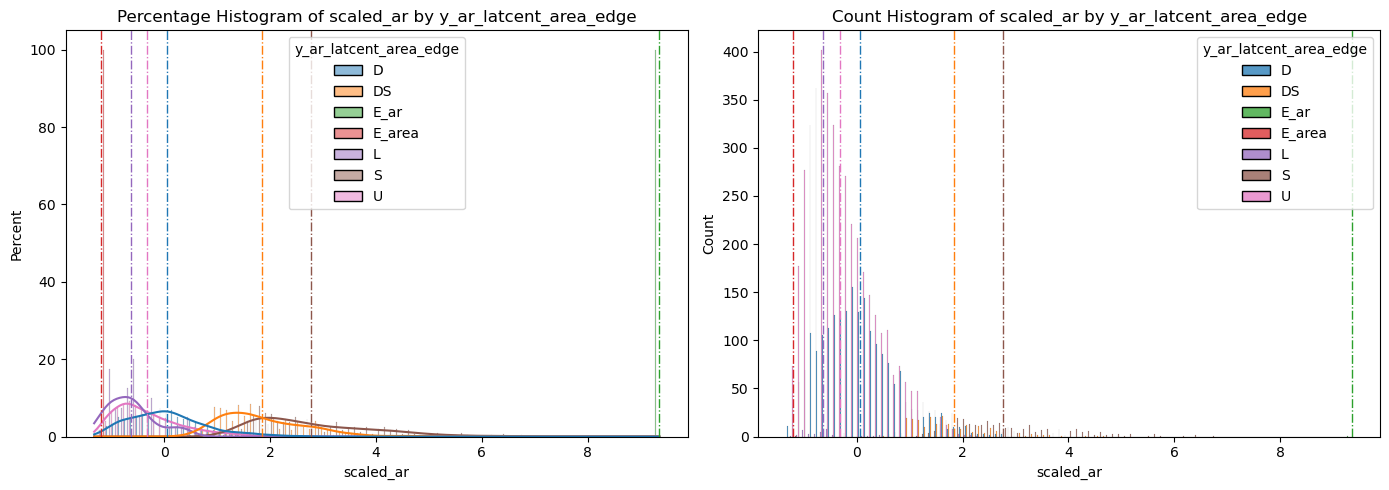

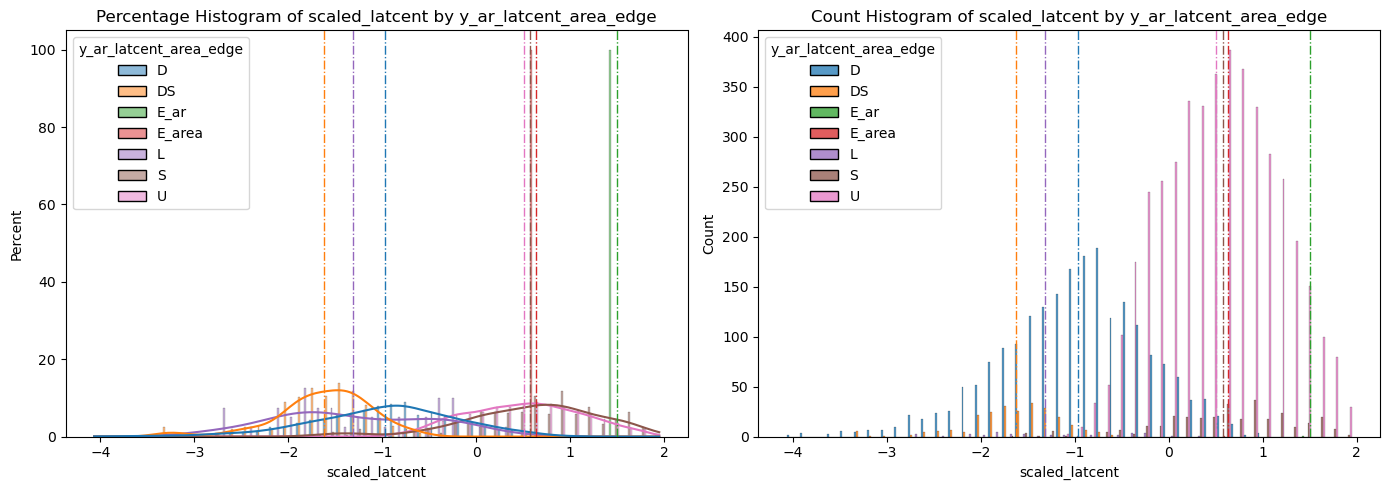

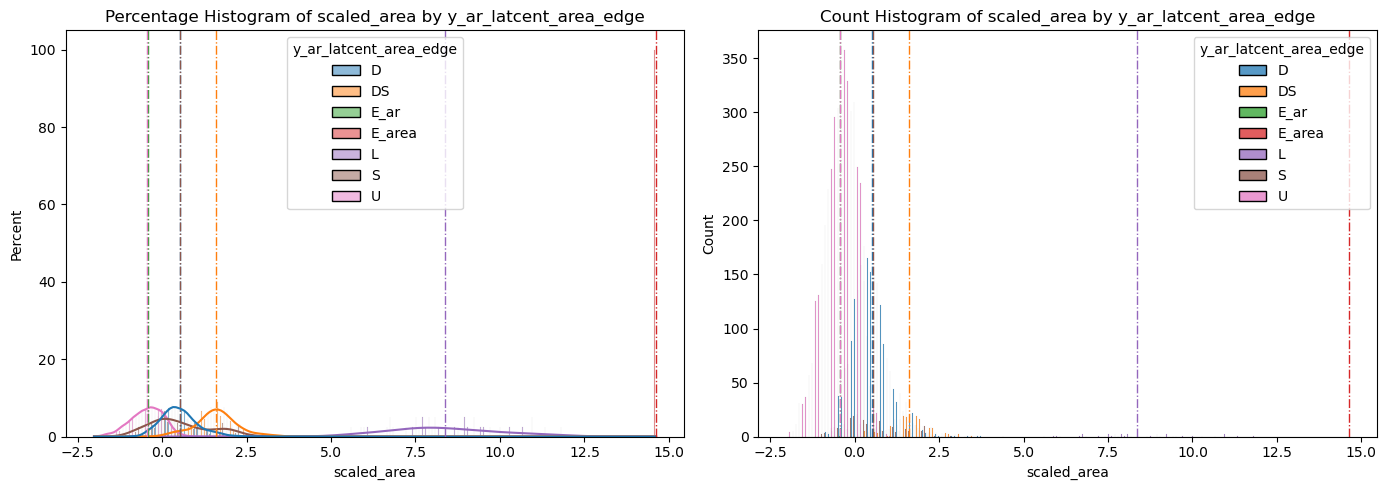

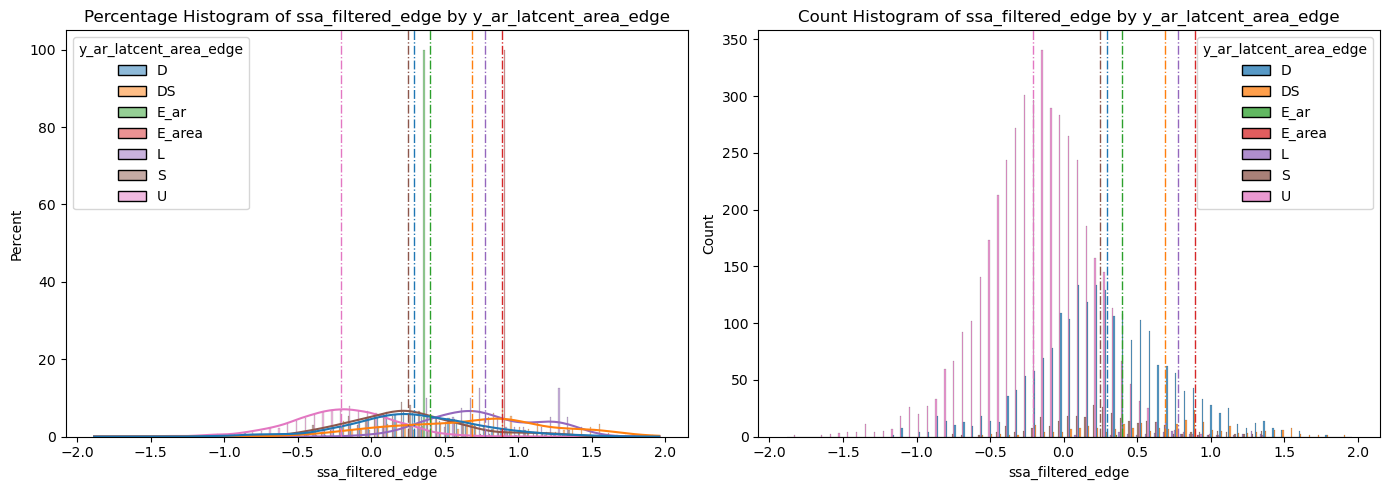

In [20]:
nwp_geo['y_ar_latcent_area_edge'] = nwp_geo['y_ar_latcent_area_edge'].replace({0: 'L', 1:'D', 2:'S', 3 : 'E_area', 4 : 'U', 5 : 'E_ar', 6 : 'DS'})

print("Averages per class and features:")
print(nwp_geo[['y_ar_latcent_area_edge', 'scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge']].groupby(['y_ar_latcent_area_edge']).mean())
print(nwp_geo[['y_ar_latcent_area_edge', 'scaled_ar', 'scaled_latcent', 'scaled_area', 'ssa_filtered_edge']].groupby(['y_ar_latcent_area_edge']).size())

plot_hist_per_class(nwp_geo, # data
                    features_kopt[2], # information about used feature and k_opt
                    'y_ar_latcent_area_edge') # column name with y values

## Physical interpretation and Literature Comparison

The following table illustrates the distribution of classes in H11:

<table>
  <tr>
    <th></th>
    <th colspan="4">AR, Latcent and filtered Area</th>
  </tr>
  <tr>
    <th>AR, Latcent</th>
    <th>D (0) </th>
    <th>U (2) </th>
    <th>S (1) </th>
    <th>Total</th>
  </tr>
  <tr>
    <th>D (2) </th>
    <td>7</td>
    <td>3</td>
    <td>0</td>
    <td>10</td>
  </tr>
  <tr>
    <th>U (1)</th>
    <td>4</td>
    <td>80</td>
    <td>2</td>
    <td>86</td>
  </tr>
  <tr>
    <th>S (0)</th>
    <td>1</td>
    <td>0</td>
    <td>3</td>
    <td>4</td>
  </tr>
  <tr>
    <th>Total</th>
    <td>12</td>
    <td>83</td>
    <td>5</td>
    <td>100</td>
  </tr>
</table>

The distribution among the classes with the wind speed as a proxy for the area is given below. The outlier is assigned to split for a better comparison.

It can be clearly seen that roughly 1.7% are neatly recognized as **split** in both models. The model using the wind speed classifies more samples as split and comes closer to a distribution resembling the one found by Hannachi et al. Both models overestimate **D** by 5-14% depending on whether the wind speed is included or not.

In [21]:
nwp_geo['y_ar_latcent_u'] = nwp_geo['y_ar_latcent_u'].replace({'E' : 'S'})

pd.pivot_table(data=nwp_geo[['y_ar_latcent', 'string','y_ar_latcent_u']], index='y_ar_latcent', columns='y_ar_latcent_u', aggfunc = 'count', margins=True)/nwp_geo.shape[0]*100

string                                 
y_ar_latcent_u          D         S          U         All
y_ar_latcent                                              
D               13.981377  0.860609   9.706546   24.548533
S                0.014108  1.693002        NaN    1.707111
U                3.414221  1.791761  68.538375   73.744357
All             17.409707  4.345372  78.244921  100.000000

Based on the aspect ratio a differentiation between split and displaced was computed. This computation is part of the elliptical indices and everything is either marked as split or displaced. All models reliably recognize the majority of the events marked as split with respect to the aspect ratio.

To compare the classification by the hierarchical models to the computed split and displaced classification, the measures of accuracy (acc), precision, recall and f1 score are introduced. They base on the notion of true positive (TP), i.e. an even is clustered and computed as split, true negative (TN), i.e. an event is not clustered as split and not computed as such, false positive (FP), i.e. an event is clustered as split, but not computed as split, and false negative (FN), i.e. an event is marked as not split, but was computed as split. The four measurements are calculated as follows:
$$
acc = \frac{TN+TP}{TP+TN+FP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
recall = \frac{TP}{TP+FN}
$$
$$
f1 = \frac{2*precision*recall}{precision+recall}
$$

For each 1 is best and 0 is worst. With respect to form, the model including the wind speed performs better than the other models as can be seen by its very high accuracy (0.98) and its high precision (0.76) and recall (0.84) values. Though only the model based on ar and latcent manages to retrieve all computed split events (recall=1.0) as split. On the other hand, it severely overestimates split events and includes a lot of false positives. This results on relatively low precision.

In [22]:
from arctic.workflows.demo import compare_cluster

compare_cluster(nwp_geo.merge(nwp_all[['string', 'form']], on='string', how='inner'), compare_col='form', pred_value='S', gt_value=1, y_names=y_names)

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs form (ground truth: 1)
y_ar_latcent      D     S      U     All
form                                    
0             24.48  0.52  73.74   98.74
1              0.07  1.19   0.00    1.26
All           24.55  1.71  73.74  100.00
Accuracy: 0.99
Precision: 0.69
Recall: 0.94
F1 Score: 0.8
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_scArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_scArea     D  E_ar  E_area     L     S      U     All
form                                                              
0                    12.1  0.00    0.01  0.56  1.51  84.55   98.74
1                     0.0  0.01    0.00  0.00  1.24   0.00    1.26
All                  12.1  0.01    0.01  0.56  2.75  84.55  100.00
Accuracy: 0.98
Precision: 0.45
Recall: 0.99
F1 Score: 0.62
----------------------------------------------
Comparison of Percentages:  y_a

Seviour et al. (2013) presented a threshold based method to recognize split and displaced events. A displaced event is defined as follows:

> Displaced events are identified if the centroid latitude remains equatorward 66ıN for 7 days or more.7

And a split event as:
> Split events are identified if the aspect ratio remains above 2.4 for 7 days or more.

Additionally, no two events can occur within 30 days and if to come so, the first event marks the classification. It can be seen, that adding the wind speed results in the best alignment with a threshold based classification as suggested by Seviour et al. (2013).

In [30]:
labels = arctic.split_displaced_seviour(nwp_geo[['ar', 'latcent', 'string']], mark='all')
nwp_geo['seviour'] = labels

compare_cluster(nwp_geo, compare_col = 'seviour', pred_value = 'S', gt_value='split', y_names=y_names)

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs seviour (ground truth: split)
y_ar_latcent      D     S      U     All
seviour                                 
displaced      2.00  0.00   0.00    2.00
split          0.01  0.23   0.00    0.24
undisturbed   22.53  1.48  73.74   97.76
All           24.55  1.71  73.74  100.00
Accuracy: 0.99
Precision: 0.13
Recall: 0.94
F1 Score: 0.23
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_scArea (predicted: S) vs seviour (ground truth: split)
y_ar_latcent_scArea      D  E_ar  E_area     L     S      U     All
seviour                                                            
displaced             1.96  0.00    0.00  0.03  0.00   0.01    2.00
split                 0.00  0.00    0.00  0.00  0.24   0.00    0.24
undisturbed          10.14  0.01    0.01  0.54  2.51  84.54   97.76
All                  12.10  0.01    0.01  0.56  2.75  84.55  100.00
Accuracy

### Compare to Major Warmings

In [29]:
for y in y_names:
    print(np.round(pd.pivot_table(nwp_geo.merge(nwp_all[['string', 'MW']], on='string', how='inner')[['MW', y, 'string']], index='MW', columns=y, aggfunc='count', margins=True)/nwp_geo.shape[0]*100,2))

             string                     
y_ar_latcent      D     S      U     All
MW                                      
0             22.28  1.52  73.72   97.52
1              2.27  0.18   0.03    2.48
All           24.55  1.71  73.74  100.00
                    string                                        
y_ar_latcent_scArea      D  E_ar E_area     L     S      U     All
MW                                                                
0                    10.31  0.01   0.01  0.34  2.29  84.55   97.52
1                     1.79   NaN    NaN  0.23  0.47    NaN    2.48
All                  12.10  0.01   0.01  0.56  2.75  84.55  100.00
                       string                                              
y_ar_latcent_area_edge      D    DS  E_ar E_area     L     S      U     All
MW                                                                         
0                       28.71  2.57  0.01   0.01  0.34  4.29  61.58   97.52
1                        1.21  0.90   NaN    NaN

### Overview of descriptive statistics for each class

Below the statistics for all features are displayed. The minimum (resp. maximum) in each column is marked violett (resp. yellow).

In [33]:
# All numeric columns excluding IDs and classifications
exclude_cols = ['string', 'counter_d', 'time_d'] + [col for col in nwp_geo.columns if col.startswith('y_')]
exclude_cols.extend(['area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1', 'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'])
numeric_cols = nwp_all.select_dtypes(include='number').columns
cols_to_summarize = [col for col in numeric_cols if (col not in exclude_cols and col not in nwp_geo.columns)]

merged = nwp_geo.merge(nwp_all[cols_to_summarize+['string']], on='string', how='inner')
summary_dict = {}

for model in y_names:
    grouped_all = merged.groupby(model)[cols_to_summarize].agg(['min', 'max', 'mean'])
    grouped_geo = nwp_geo.groupby(model)[nwp_geo.select_dtypes(include='number').columns[3:]].agg(['min', 'max', 'mean'])
    summary_dict[model] = [grouped_all, grouped_geo]

pd.set_option('display.precision', 2)
for model, df in summary_dict.items():
    print(f"\n Summary statistics from remaining data for {model}:")
    all = df[0]
    train_features = df[1]
    display(all.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))
    print(f"\n Summary statistics from data used to train {model}:")
    display(train_features.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))


 Summary statistics from remaining data for y_ar_latcent:



 Summary statistics from data used to train y_ar_latcent:



 Summary statistics from remaining data for y_ar_latcent_scArea:



 Summary statistics from data used to train y_ar_latcent_scArea:



 Summary statistics from remaining data for y_ar_latcent_area_edge:



 Summary statistics from data used to train y_ar_latcent_area_edge:



 Summary statistics from remaining data for y_ar_latcent_u:



 Summary statistics from data used to train y_ar_latcent_u:


### Schematic plot of vortex of representative sample for each found cluster

For each cluster the means of certain features is computed. Then, the closest sample in the used data is determined by its euclidean distance. This samples is chosen as a representative and a day before and after is included in the plots to illustrate the vortex evolution.

y:  y_ar_latcent
class:  U
Representative mean has class:  U
Plotted vortices have classes:  ['U', 'U', 'U']


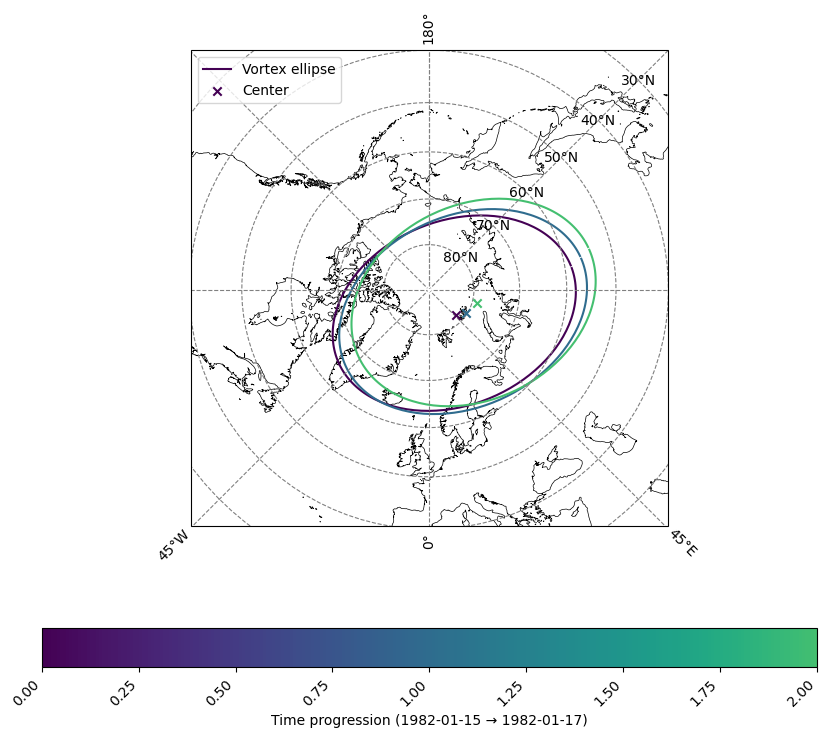

class:  S
Representative mean has class:  S
Plotted vortices have classes:  ['U', 'S', 'S']
split event in time range


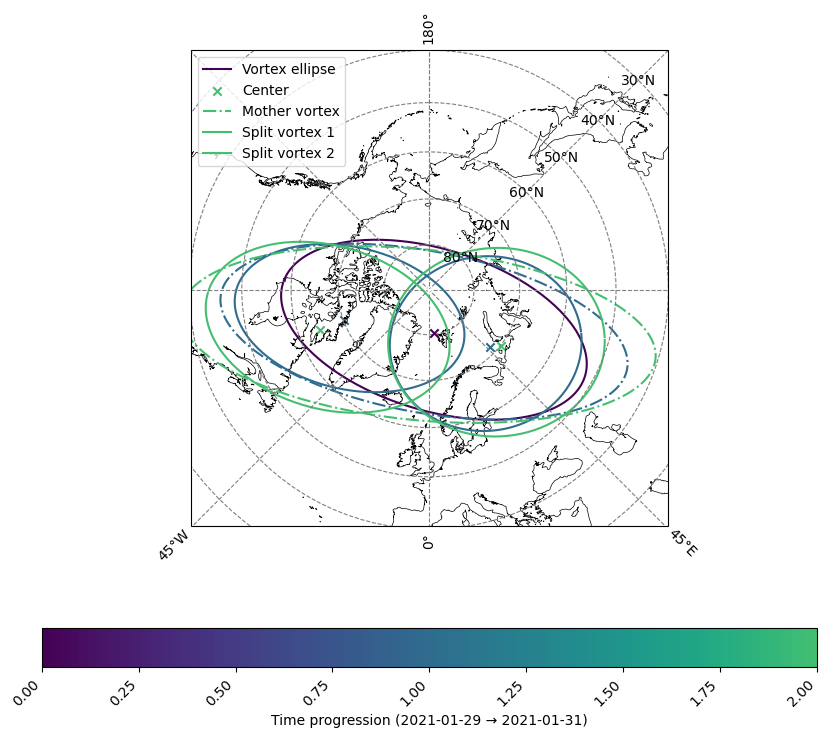

class:  D
Representative mean has class:  D
Plotted vortices have classes:  ['D', 'D', 'D']


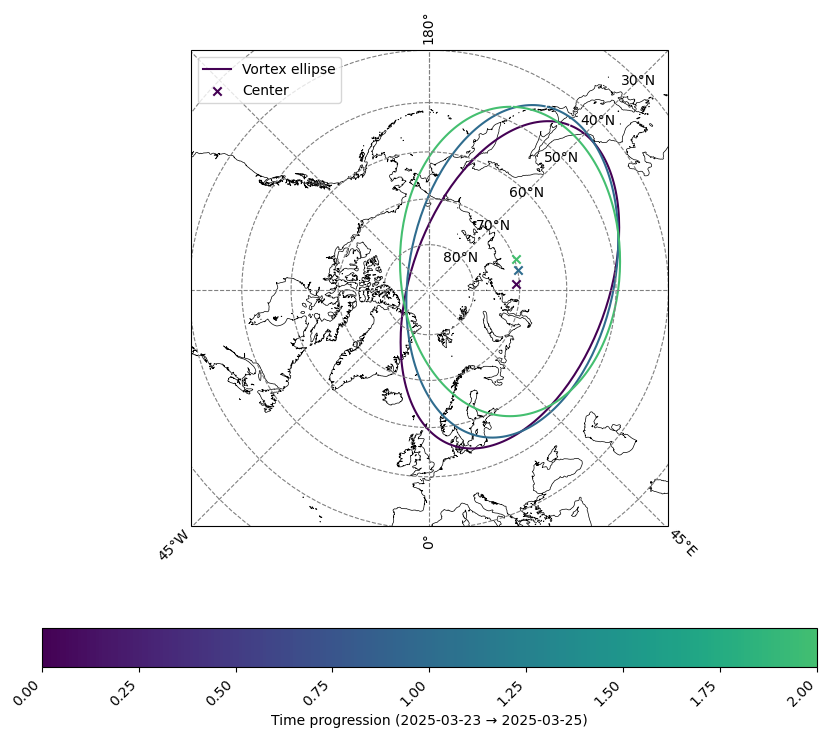

y:  y_ar_latcent_scArea
class:  U
Representative mean has class:  U
Plotted vortices have classes:  ['U', 'U', 'U']


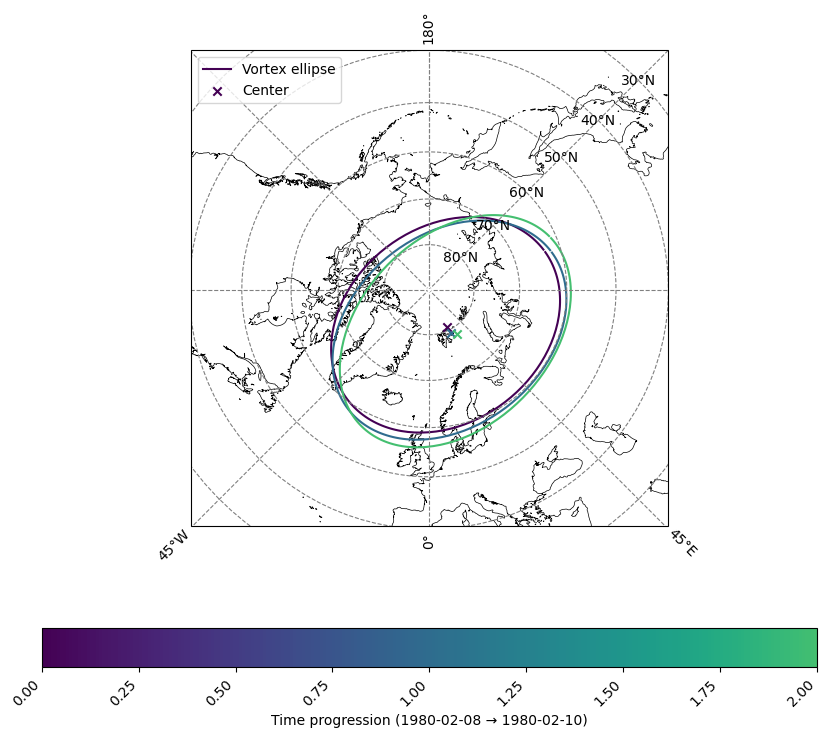

class:  S
Representative mean has class:  S
Plotted vortices have classes:  ['S', 'S', 'U']
split event in time range


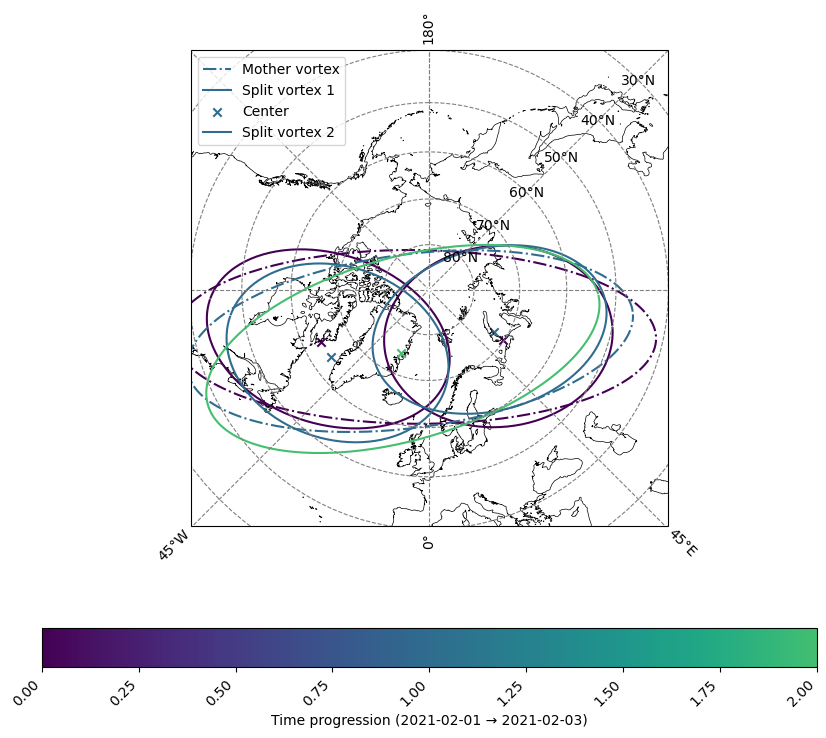

class:  D
Representative mean has class:  D
Plotted vortices have classes:  ['D', 'D', 'D']


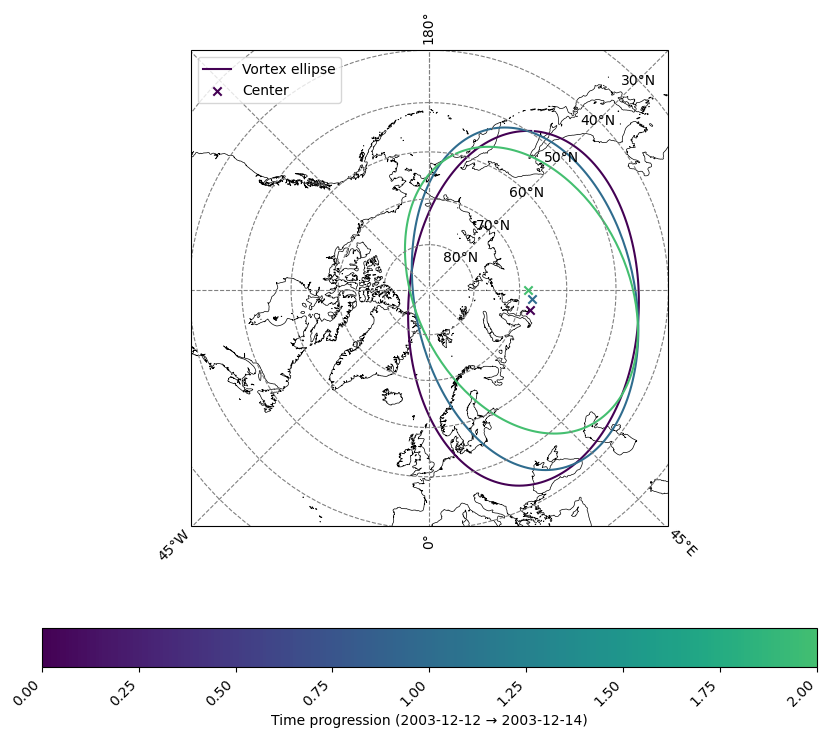

class:  E_ar
Representative mean has class:  E_ar
Plotted vortices have classes:  ['S', 'E_ar', 'S']
split event in time range


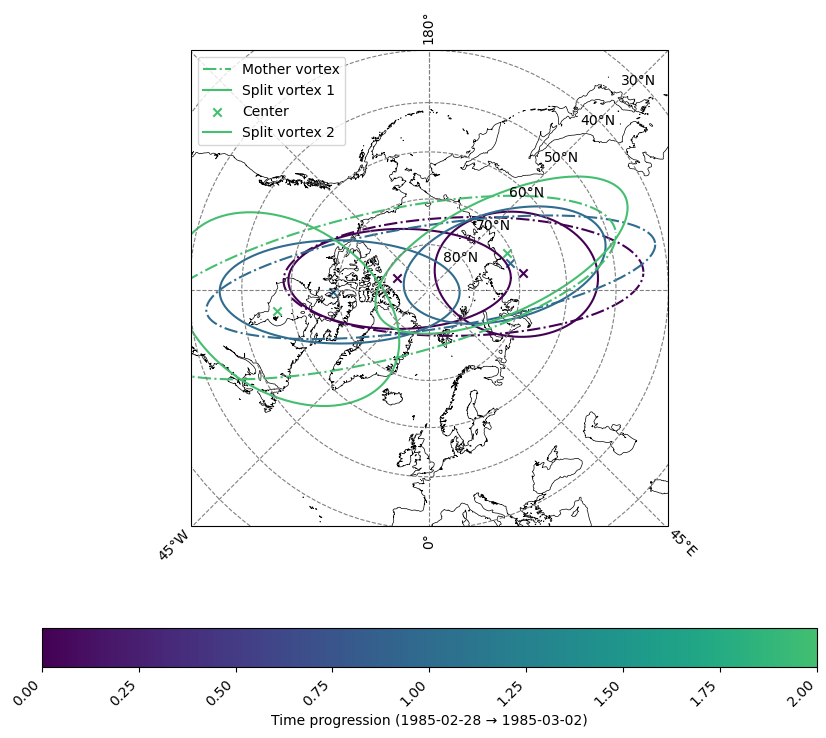

class:  L
Representative mean has class:  L
Plotted vortices have classes:  ['L', 'L', 'L']
MW event in time range


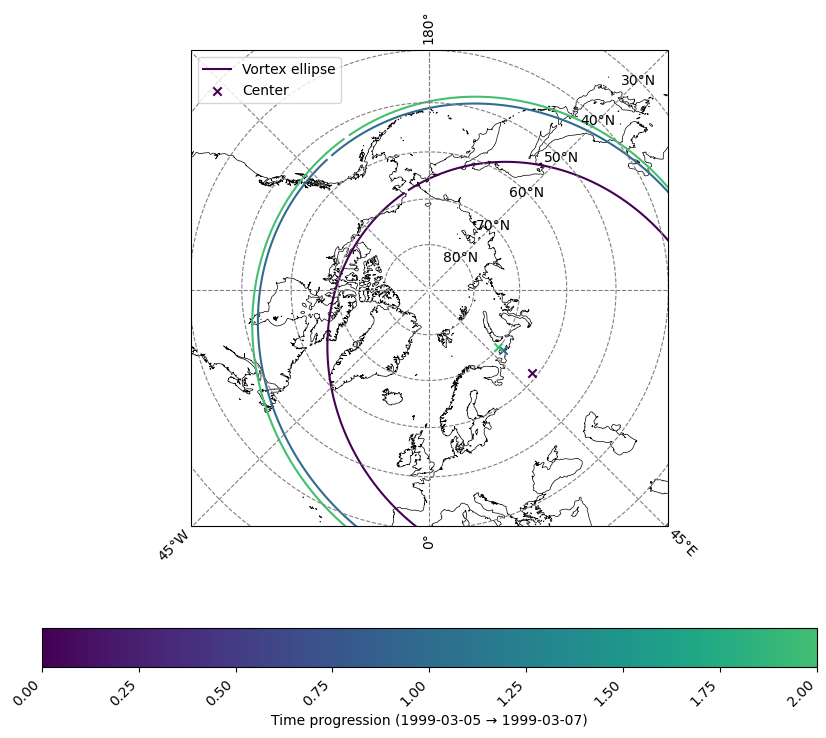

class:  E_area
Representative mean has class:  E_area
Plotted vortices have classes:  ['L', 'E_area', 'L']


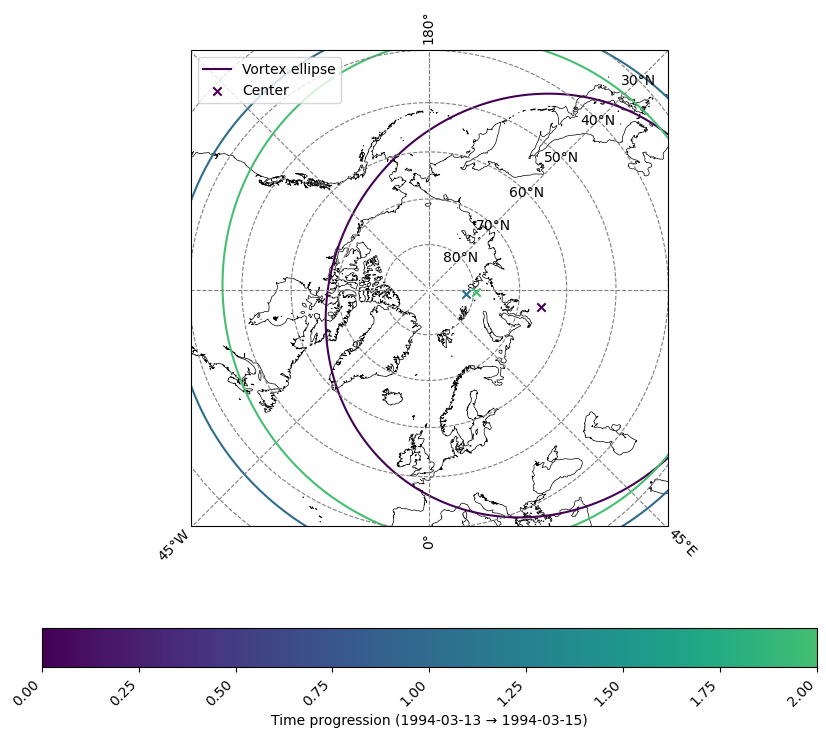

y:  y_ar_latcent_area_edge
class:  U
Representative mean has class:  U
Plotted vortices have classes:  ['U', 'U', 'U']


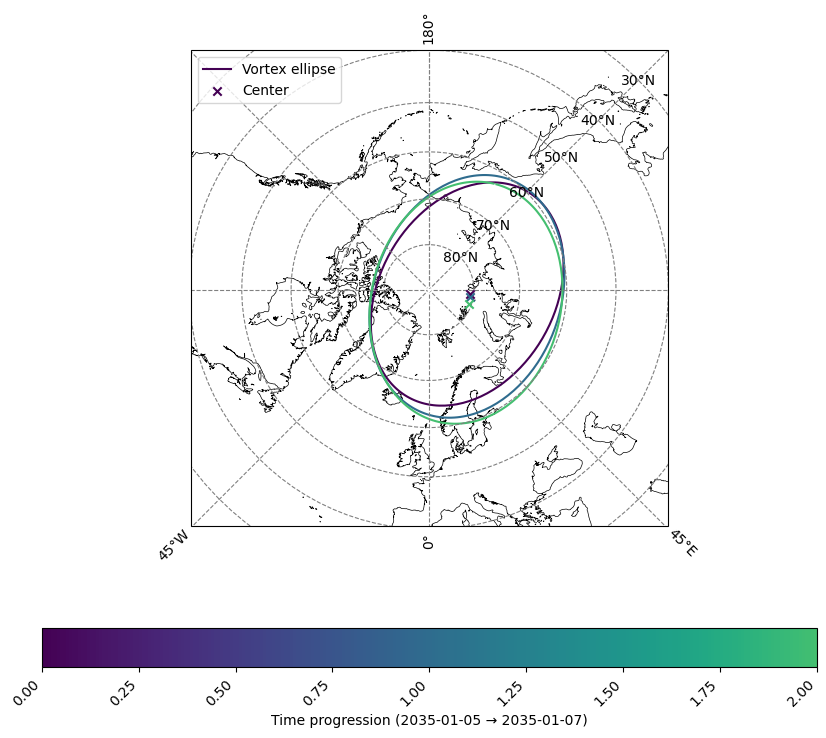

class:  S
Representative mean has class:  S
Plotted vortices have classes:  ['S', 'S', 'D']


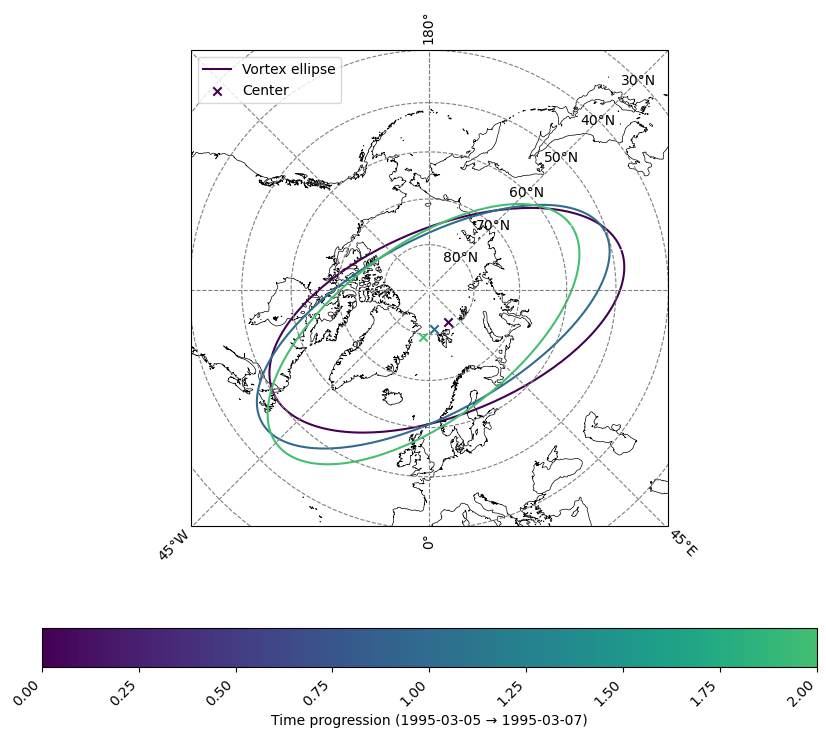

class:  D
Representative mean has class:  D
Plotted vortices have classes:  ['D', 'D', 'D']


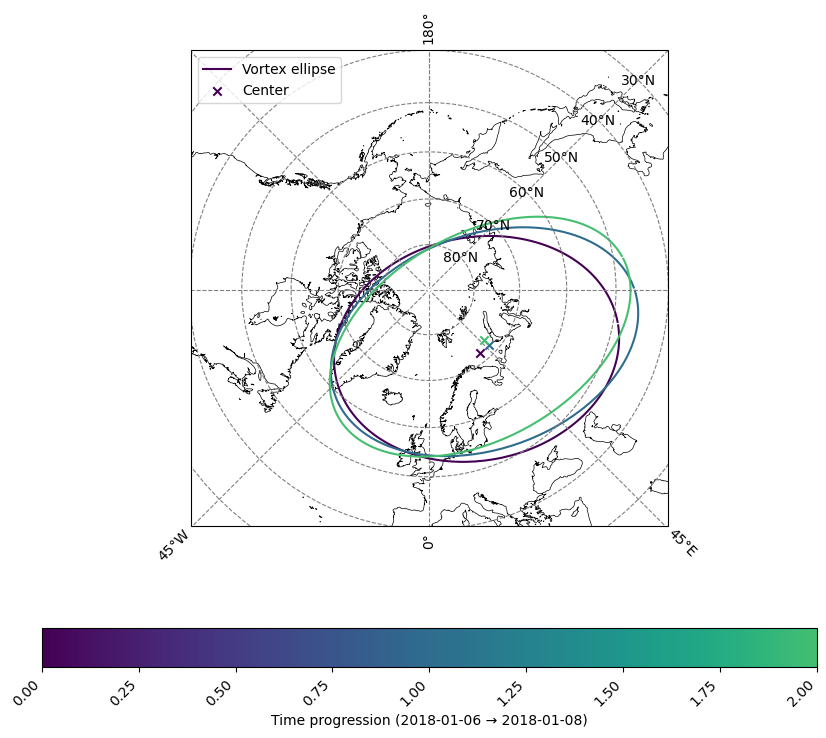

class:  DS
Representative mean has class:  DS
Plotted vortices have classes:  ['DS', 'DS', 'DS']


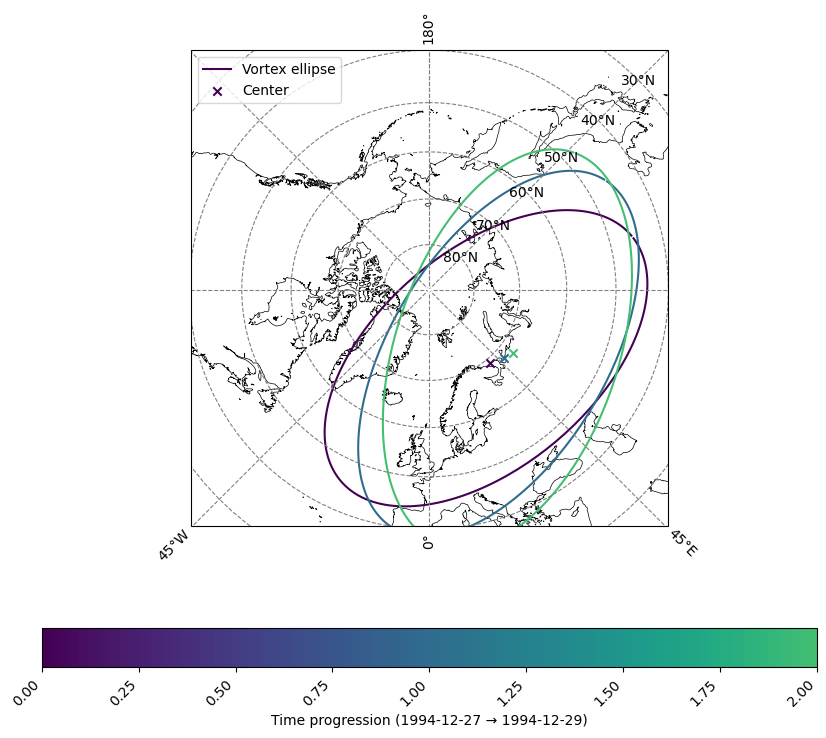

class:  E_ar
Representative mean has class:  E_ar
Plotted vortices have classes:  ['S', 'E_ar', 'S']
split event in time range


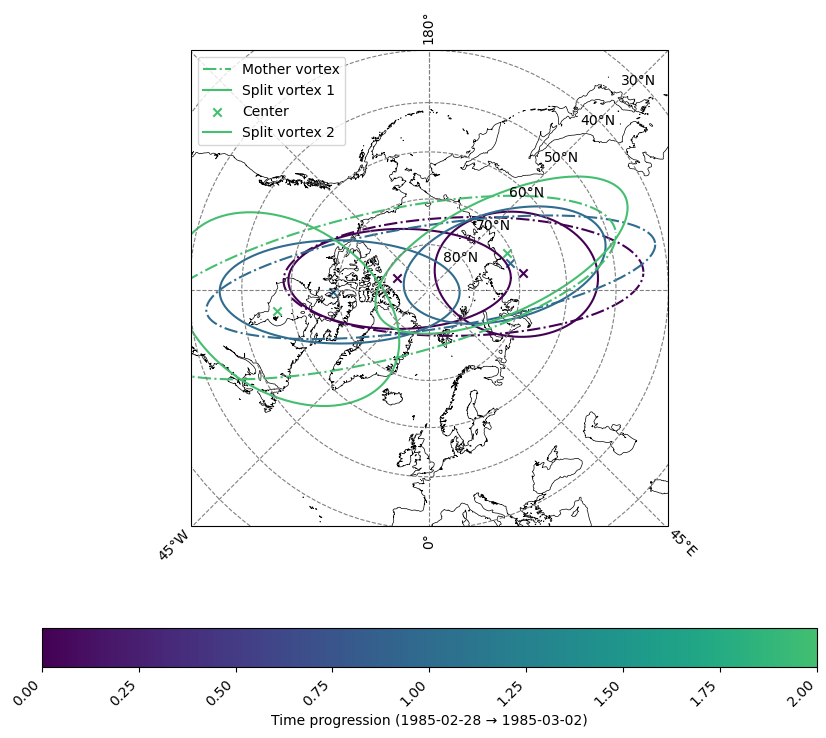

class:  L
Representative mean has class:  L
Plotted vortices have classes:  ['L', 'L', 'L']
MW event in time range


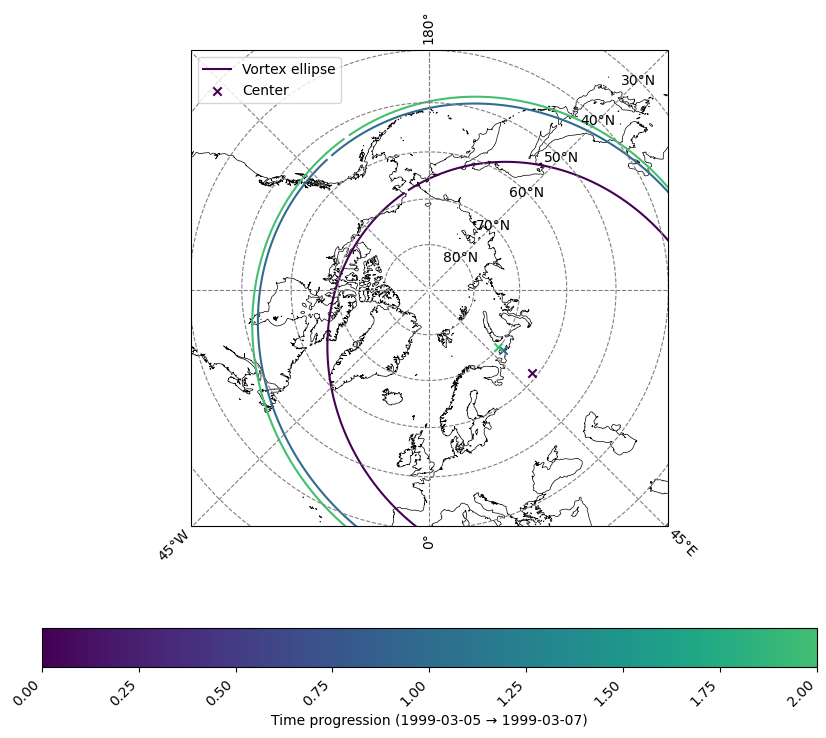

class:  E_area
Representative mean has class:  E_area
Plotted vortices have classes:  ['L', 'E_area', 'L']


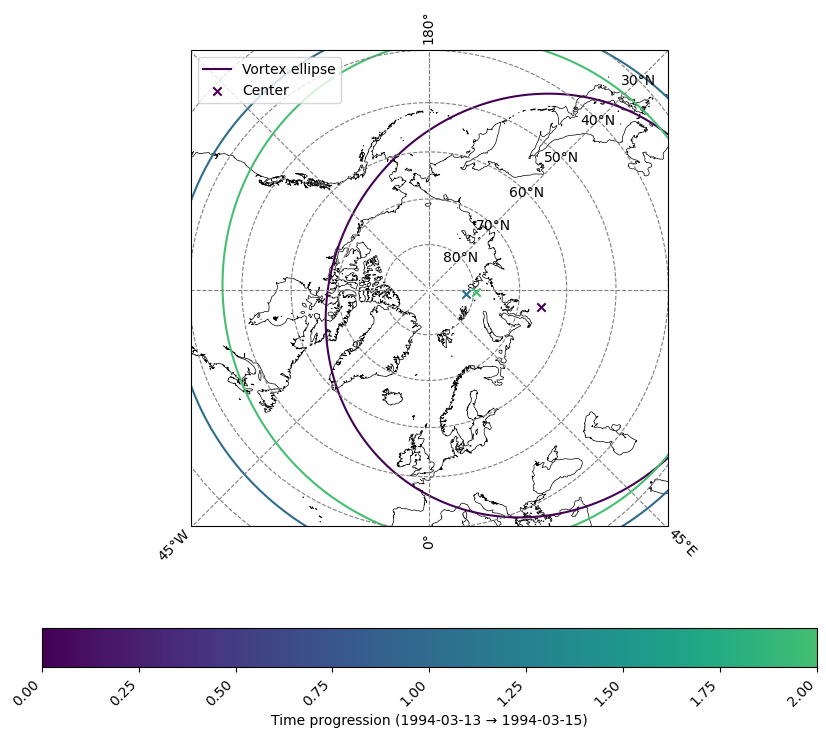

y:  y_ar_latcent_u
class:  U
Representative mean has class:  U
Plotted vortices have classes:  ['U', 'U', 'U']


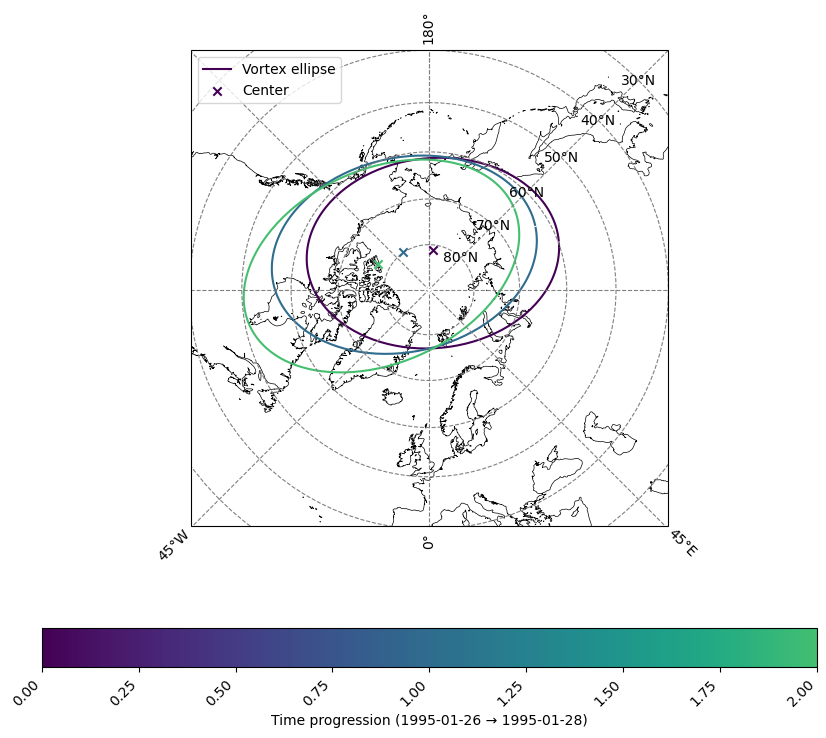

class:  S
Representative mean has class:  S
Plotted vortices have classes:  ['S', 'S', 'S']


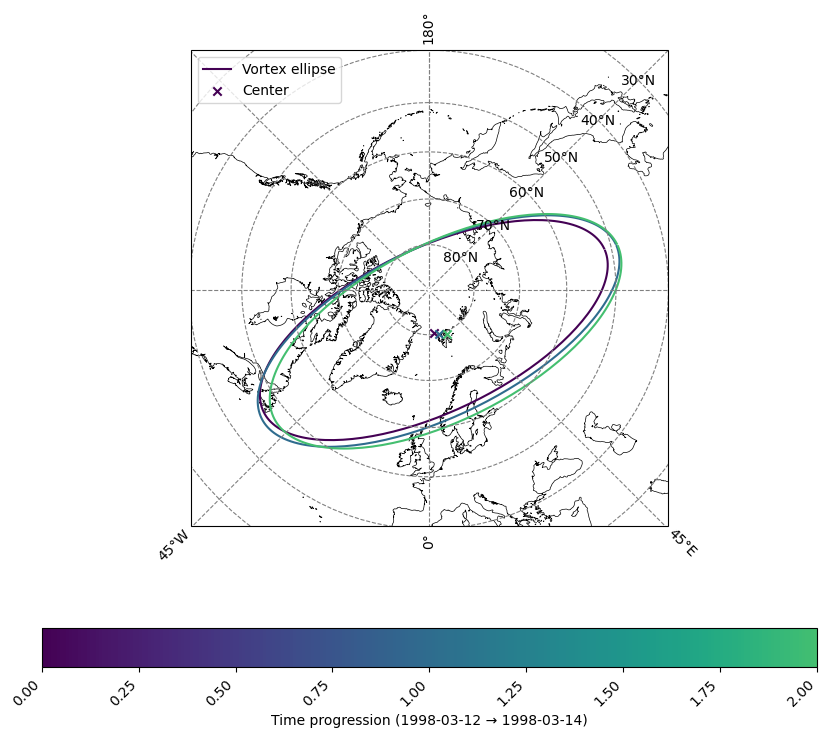

class:  D
Representative mean has class:  D
Plotted vortices have classes:  ['D', 'D', 'U']


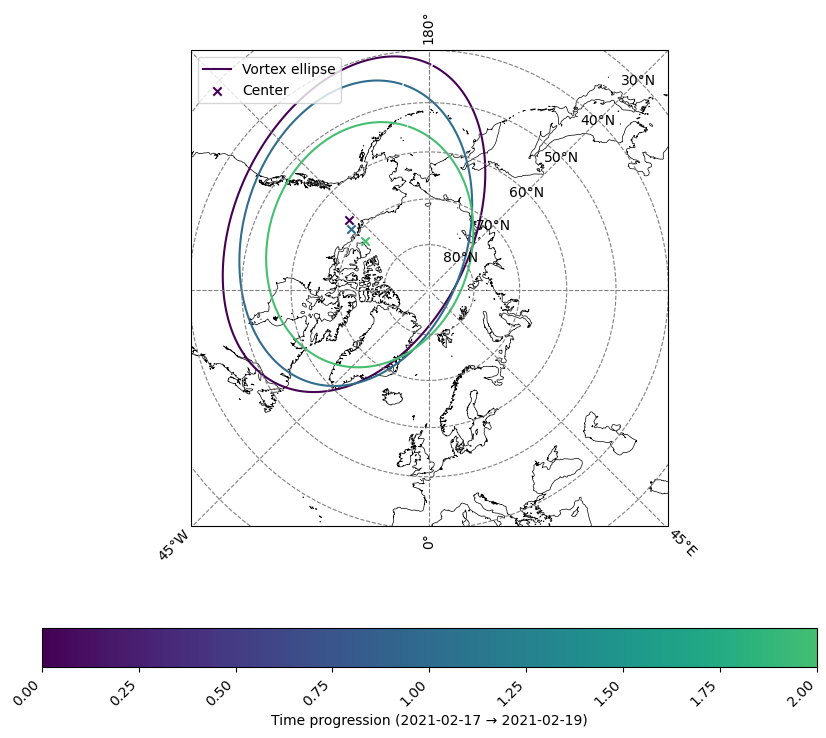

In [52]:
from sklearn.metrics.pairwise import euclidean_distances
from datetime import timedelta

foi = ['ar', 'latcent', 'kurtosis',
       'scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis',
       'ssa_filtered_u']
for y in y_names:
    print('y: ', y)
    for c in nwp_geo[y].unique():
        print('class: ', c)
        # compute all means
        mean_vec = nwp_geo[nwp_geo[y] == c][foi].mean()
        # compute distance of each sample to mean
        dist_mean = euclidean_distances(nwp_geo[foi], [mean_vec])
        # determine index of sample closest to mean
        mean_idx = dist_mean.argmin()
        # obtain representative sample
        rep_mean = nwp_geo.iloc[mean_idx]
        print("Representative mean has class: ", rep_mean[y])

        dates = [rep_mean.string + timedelta(days=i) for i in range(-1, 2)]
        samples = nwp_all[nwp_all.string.isin(dates)]

        print("Plotted vortices have classes: ", nwp_geo[nwp_geo.string.isin(dates)][y].tolist())

        if samples.form.sum() > 0:
            print('split event in time range')
        if samples.MW.sum() > 0:
            print('MW event in time range')

        arctic.plot_polar_stereo(samples, time_col='string', mode='overlay', figsize=(15,15))

# Appendix
For reasons of interest in the data the following was kept.

## Computation of the partial autocorrelation function
The partial autocorrelation function does not exhibit any remarkable perks except for the wind speed reduced to DJFM. The visible peaks correspond closely to the suggested time window of 120 days and indicate a 120d periodic signal in the data.

In [59]:
# scaling of all data
sc = StandardScaler()
nwp_all[['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_u']] = sc.fit_transform(nwp_all[['area', 'ar', 'latcent', 'u']])

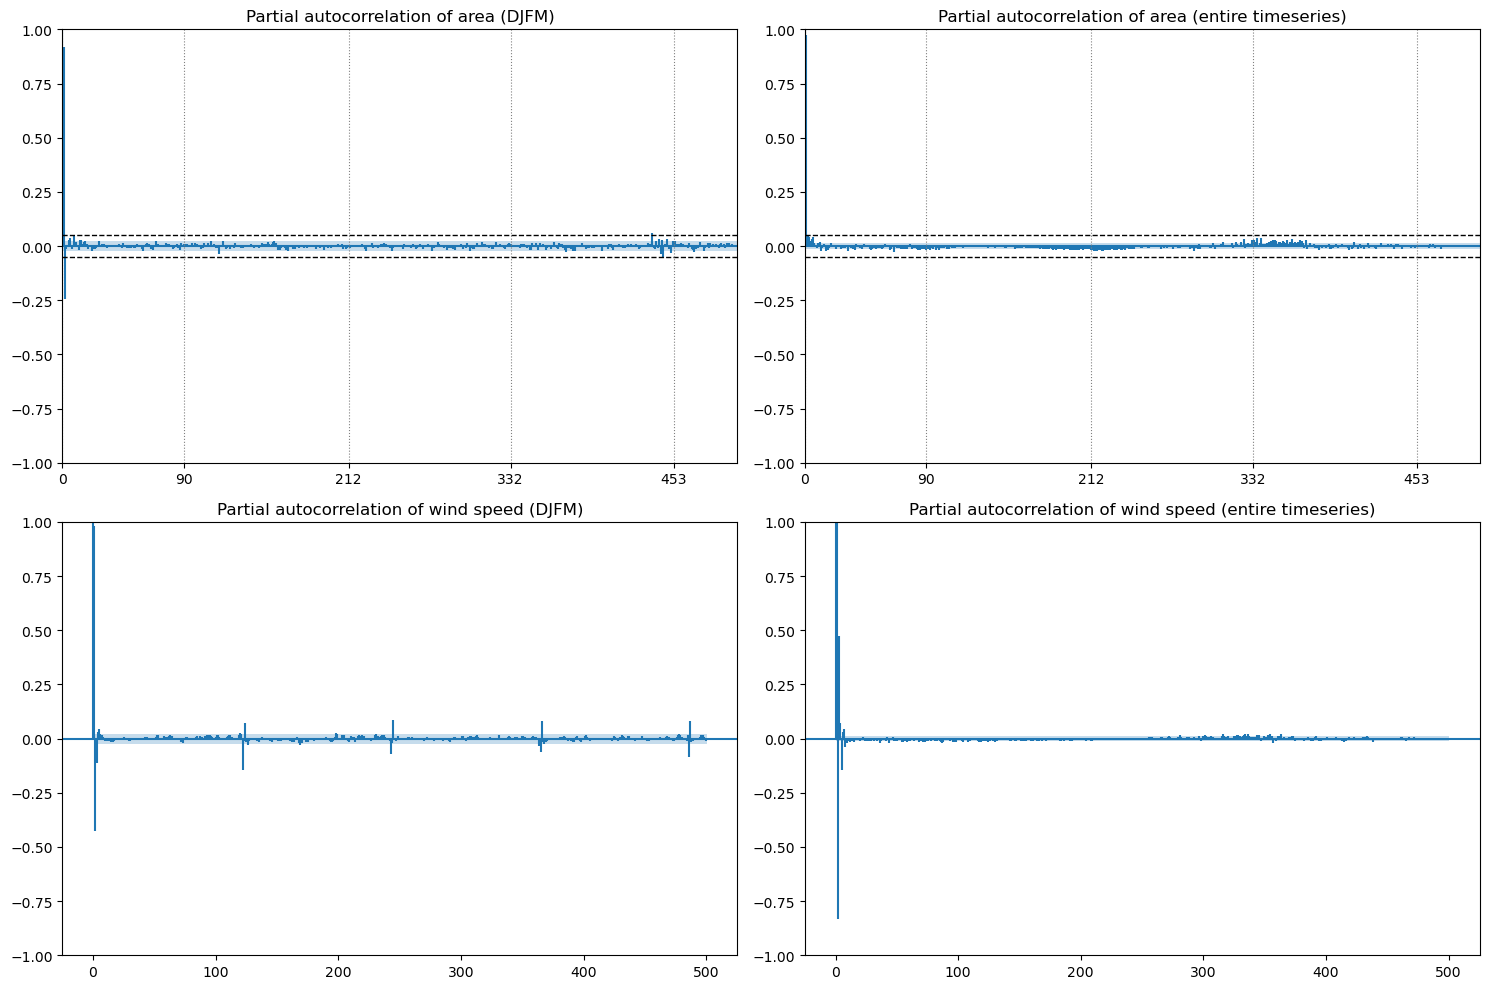

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(2,2, figsize=(15, 10))
ax = ax.flatten()
plot_pacf(nwp_geo['scaled_area'], lags=500, ax=ax[0], label='PACF scaled area (DJFM)', marker=None)
plot_pacf(nwp_all['scaled_area'], lags=500, ax=ax[1], label='PACF scaled area (entire timeseries)', marker=None)
plot_pacf(nwp_geo['scaled_u'], lags=500, ax=ax[2], label='PACF wind speed (DJFM)', marker=None)
plot_pacf(nwp_all['scaled_u'], lags=500, ax=ax[3], label='PACF wind speed (entire timeseries)', marker=None)

ax[0].set_title('Partial autocorrelation of area (DJFM)')
ax[1].set_title('Partial autocorrelation of area (entire timeseries)')
ax[2].set_title('Partial autocorrelation of wind speed (DJFM)')
ax[3].set_title('Partial autocorrelation of wind speed (entire timeseries)')

for i in range(2):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 500)
    ax[i].set_xticks(positions[:5])
    for x in positions:
        ax[i].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

## Year over Year averages

Below the yearly seasonality is computed with the year over year average as well as the reconstruction of the yearly seasonality with SSA.

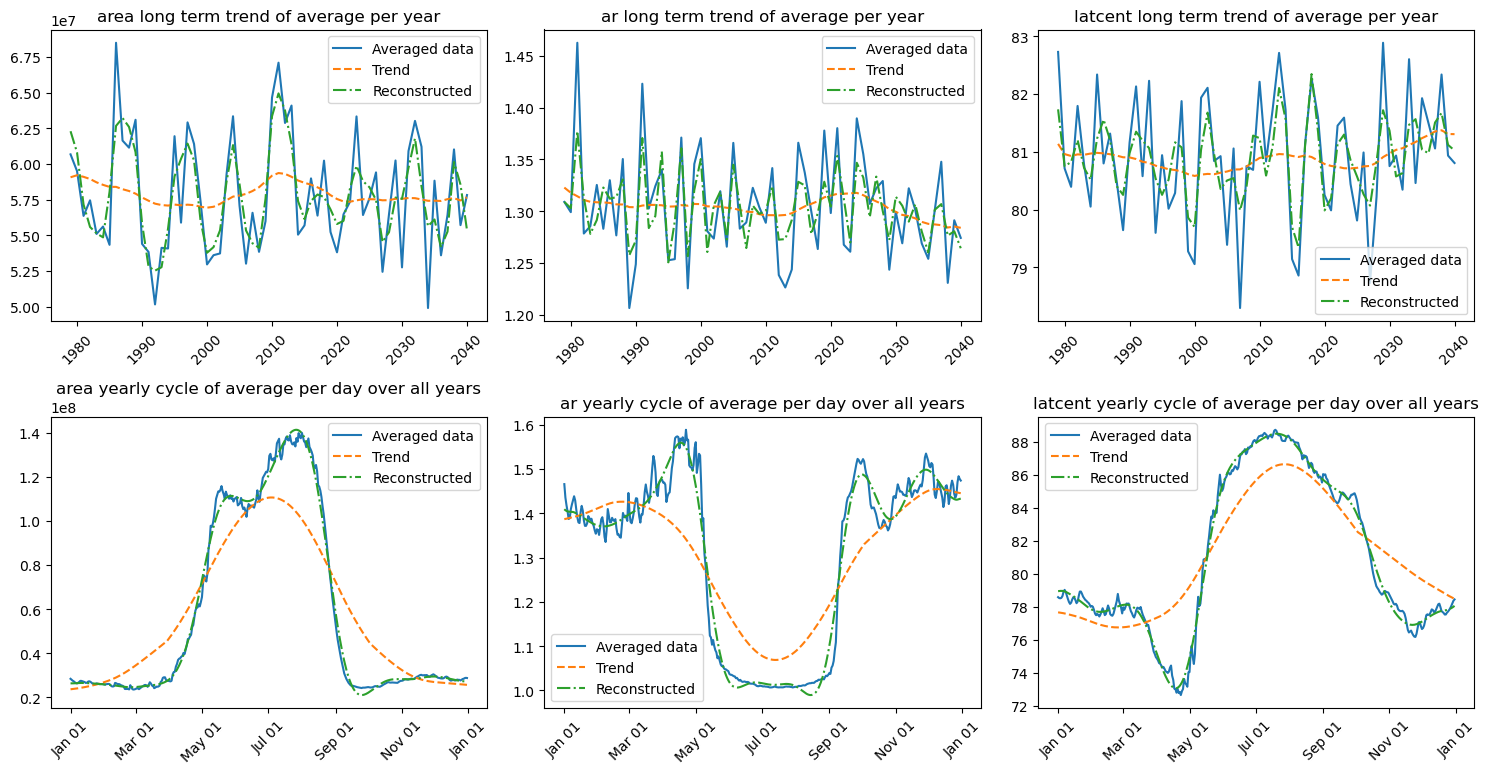

In [62]:
from arctic.workflows.demo import plot_ssa_grid
# Average data
avg_year = nwp_all.groupby('year').mean()
avg_year.index = pd.to_datetime(avg_year.index, format='%Y')

avg_day_over_year = nwp_all.groupby(['month', 'day']).mean()
avg_day_over_year.index = pd.to_datetime({"year": 2000,  # just a sample year, not displayed in plot
                                          "month": avg_day_over_year.index.get_level_values(0),
                                          "day": avg_day_over_year.index.get_level_values(1)})
# compute SSA
ssa_long_term = SingularSpectrumAnalysis(window_size=10)
ssa_yearly_cycle = SingularSpectrumAnalysis(window_size=90)

long_term_area = ssa_long_term.fit_transform(avg_year['area'].values.reshape(1, -1))
long_term_ar = ssa_long_term.fit_transform(avg_year['ar'].values.reshape(1, -1))
long_term_latcent = ssa_long_term.fit_transform(avg_year['latcent'].values.reshape(1, -1))

year_seasonality_area = ssa_yearly_cycle.fit_transform(avg_day_over_year['area'].values.reshape(1, -1))
year_seasonality_ar = ssa_yearly_cycle.fit_transform(avg_day_over_year['ar'].values.reshape(1, -1))
year_seasonality_latcent = ssa_yearly_cycle.fit_transform(avg_day_over_year['latcent'].values.reshape(1, -1))

# Plot SSA
plot_ssa_grid(
    data_series=[avg_year, avg_day_over_year],
    ssa_results=[[long_term_area, long_term_ar, long_term_latcent],
                 [year_seasonality_area, year_seasonality_ar, year_seasonality_latcent]],
    index_format=['%Y', '%b %d'],
    labels=['area', 'ar', 'latcent'],
    titles=['long term trend of average per year', 'yearly cycle of average per day over all years'],
    used_signals=4
)

## Abbreviations

|         |                                                |
|--------:|:-----------------------------------------------|
|     H11 | Hannachi et al. 2011                           |
|     IAP | Institute for Atmospheric Physics Kühlungsborn |
|    DJFM | December, January, February, March             |
|      ar | Aspect ratio                                   |
| latcent | centroid latitude                              |
|     SSW | Sudden Stratospheric Warming                   |
|       S | Cluster of split vortices                      |
|       D | Cluster of displaced vortices                  |
|       L | Cluster of large vortices                      |
|       U | Cluster of undisturbed vortices                |
|      E  | Cluster of extreme samples                     |
|     ACF | Autocorrelation function                       |
|    PACF | Partial Autocorrelation function               |